Step 1: Scale to same Dimension

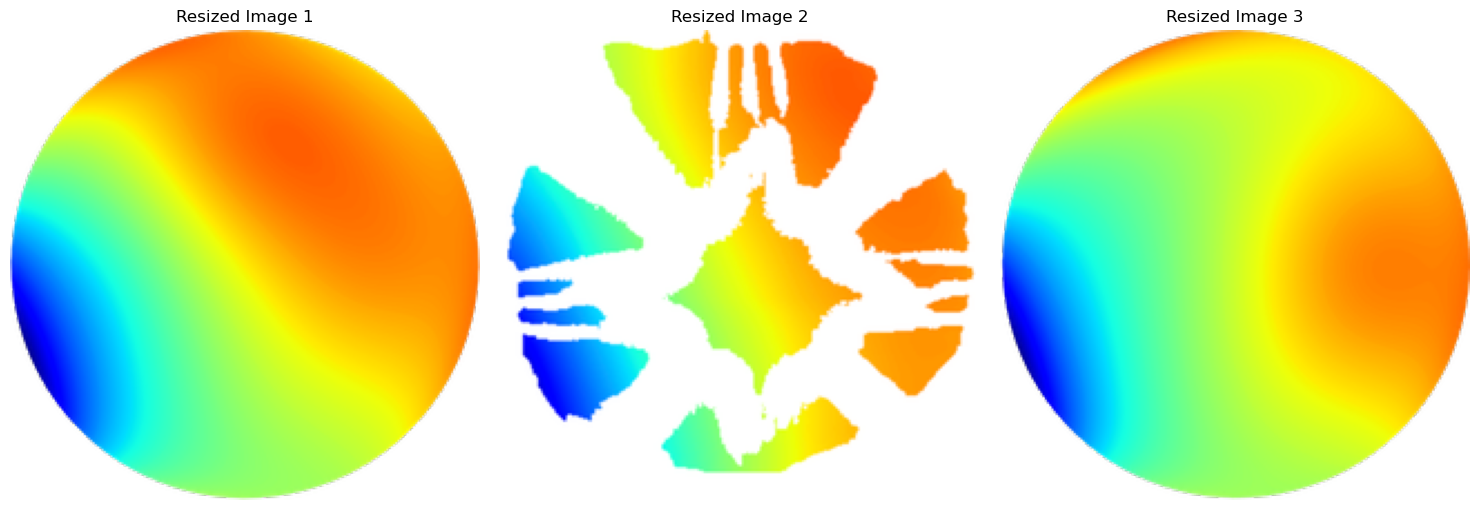

In [11]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# Load the images
image1_path = 'data/button.png'
image2_path = 'data/image3.png'
image3_path = 'data/top.png'

image1 = Image.open(image1_path)
image2 = Image.open(image2_path)
image3 = Image.open(image3_path)

# Find the smallest size among all three images
smallest_size = min(
    image1.size[0], image1.size[1],
    image2.size[0], image2.size[1],
    image3.size[0], image3.size[1]
)
smallest_size = 211
# Resize all three images to the smallest size using the updated resampling method
image1_resized = image1.resize((smallest_size, smallest_size), Image.Resampling.LANCZOS)
image2_resized = image2.resize((smallest_size, smallest_size), Image.Resampling.LANCZOS)
image3_resized = image3.resize((smallest_size, smallest_size), Image.Resampling.LANCZOS)

# Convert images to numpy matrices
image1_matrix = np.array(image1_resized)
image2_matrix = np.array(image2_resized)
image3_matrix = np.array(image3_resized)

# Save the processed matrices
np.save('data/image1_matrix.npy', image1_matrix)
np.save('data/image2_matrix.npy', image2_matrix)
np.save('data/image3_matrix.npy', image3_matrix)

# Plot the resized images
plt.figure(figsize=(15, 5))

# Plot the first image
plt.subplot(1, 3, 1)
plt.title("Resized Image 1")
plt.imshow(image1_resized)
plt.axis('off')

# Plot the second image
plt.subplot(1, 3, 2)
plt.title("Resized Image 2")
plt.imshow(image2_resized)
plt.axis('off')

# Plot the third image
plt.subplot(1, 3, 3)
plt.title("Resized Image 3")
plt.imshow(image3_resized)
plt.axis('off')

plt.tight_layout()
plt.show()

Step 2: Extract colormap

In [12]:
# import numpy as np
# import matplotlib.pyplot as plt
# from matplotlib.image import imread

# def extract_colorbar(image_path):
#     # Read the image
#     img = imread(image_path)
    
#     # Create figure for point selection
#     fig, ax = plt.subplots()
#     ax.imshow(img)
#     ax.set_title('Click two points to define color bar range\nClose window when done')
    
#     # Get points from user clicks
#     points = plt.ginput(2)
#     plt.close()
    
#     if len(points) != 2:
#         return None
    
#     # Extract coordinates
#     (x1, y1), (x2, y2) = points
#     x1, y1 = int(x1), int(y1)
#     x2, y2 = int(x2), int(y2)
    
#     # Extract RGB values along vertical line
#     rgb_values = []
#     for y in range(min(y1, y2), max(y1, y2) + 1):
#         rgb_values.append(img[y, x1])
    
#     rgb_values = np.array(rgb_values)
    
#     return rgb_values

# def plot_colorbar(rgb_values):
#     # Create figure
#     plt.figure(figsize=(2, 8))
    
#     # Create color bar using extracted RGB values
#     height = len(rgb_values)
#     color_array = np.tile(rgb_values, (20, 1, 1))  # Make it wider for visibility
    
#     plt.imshow(color_array)
#     plt.axis('off')
#     plt.title('Extracted Color Bar')
#     plt.show()

# # Main execution
# if __name__ == "__main__":
#     image_path = "scalebar.png"
#     try:
#         rgb_values = extract_colorbar(image_path)
#         if rgb_values is not None:
#             print(f"Extracted {len(rgb_values)} RGB values")
#             plot_colorbar(rgb_values)
#             # Save RGB values if needed
#             np.save('colorbar_values.npy', rgb_values)
#     except Exception as e:
#         print(f"Error: {e}")

Step 3: Map back

Loading data...
Creating color mapping...
Processing image 1...
Processing row 0/211
Processing row 50/211
Processing row 100/211
Processing row 150/211
Processing row 200/211


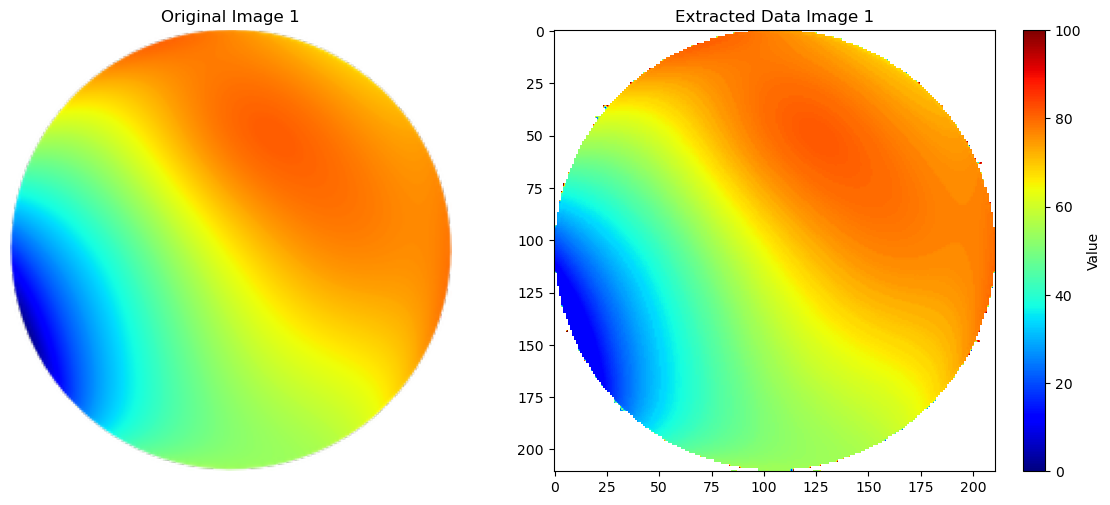

Processing image 2...
Processing row 0/211
Processing row 50/211
Processing row 100/211
Processing row 150/211
Processing row 200/211


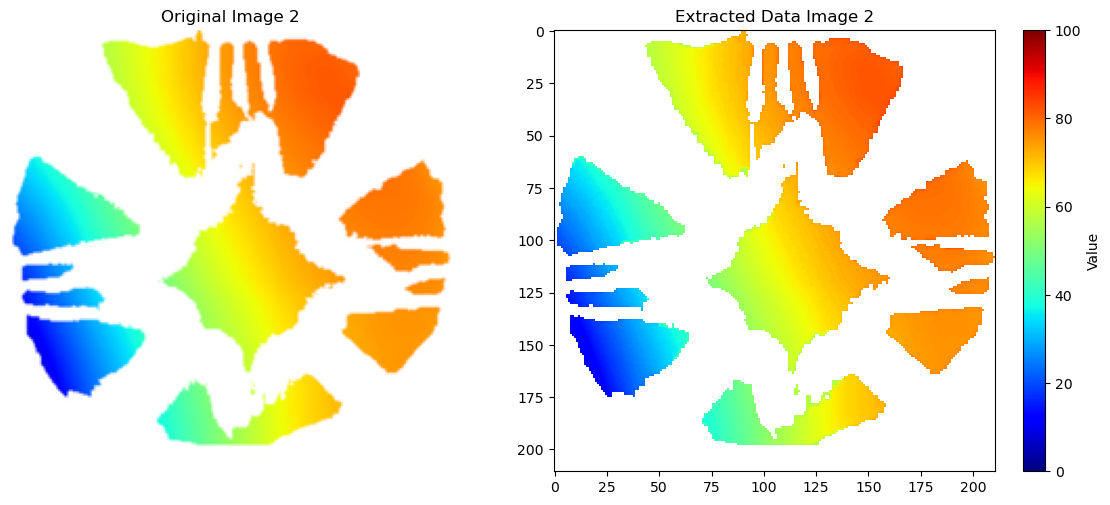

Processing image 3...
Processing row 0/211
Processing row 50/211
Processing row 100/211
Processing row 150/211
Processing row 200/211


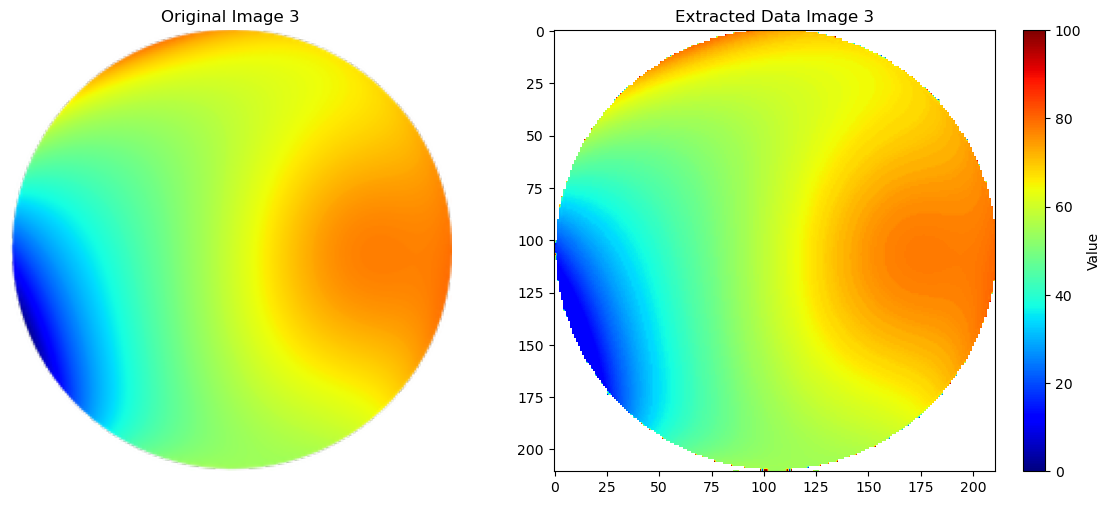

Saving results...


In [13]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import colorsys

def rgb_to_hsv(rgb):
    r, g, b = rgb[0]/255.0, rgb[1]/255.0, rgb[2]/255.0
    h, s, v = colorsys.rgb_to_hsv(r, g, b)
    return h, s, v

def hue_distance(h1, h2):
    diff = abs(h1 - h2)
    return min(diff, 1.0 - diff)

def load_data():
    image1_matrix = np.load('data/image1_matrix.npy')
    image2_matrix = np.load('data/image2_matrix.npy')
    image3_matrix = np.load('data/image3_matrix.npy')  # Added image3
    colorbar_values = np.load('colorbar_values.npy')
    return image1_matrix, image2_matrix, image3_matrix, colorbar_values  # Return image3

def create_value_mapping(colorbar_values):
    num_values = len(colorbar_values)
    numerical_values = np.linspace(0, 100, num_values)
    
    hsv_values = []
    for rgb in colorbar_values:
        h, s, v = rgb_to_hsv(rgb)
        hsv_values.append((h, s, v))
    
    return numerical_values, np.array(hsv_values)

def is_white_pixel(pixel, threshold=250):
    if len(pixel) == 4:
        r, g, b, a = pixel
        if a == 0:
            return 1
        else:
            return all(value >= threshold for value in [r, g, b])
    else:
        return all(value >= threshold for value in pixel)

def find_nearest_value(pixel_rgb, colorbar_hsv, mapped_values):
    if is_white_pixel(pixel_rgb):
        return np.nan
    
    rgb_values = pixel_rgb[:3] if len(pixel_rgb) == 4 else pixel_rgb
    pixel_h, pixel_s, pixel_v = rgb_to_hsv(rgb_values)
    
    distances = []
    for ref_hsv in colorbar_hsv:
        ref_h = ref_hsv[0]
        hue_dist = hue_distance(pixel_h, ref_h)
        sat_dist = abs(pixel_s - ref_hsv[1])
        val_dist = abs(pixel_v - ref_hsv[2])
        total_dist = hue_dist * 0.6 + sat_dist * 0.2 + val_dist * 0.2
        distances.append(total_dist)
    
    nearest_idx = np.argmin(distances)
    return 100 - mapped_values[nearest_idx]

def process_image(image_matrix, colorbar_hsv, mapped_values):
    height, width = image_matrix.shape[:2]
    result_matrix = np.zeros((height, width))
    
    for i in range(height):
        for j in range(width):
            pixel_rgb = image_matrix[i, j]
            result_matrix[i, j] = find_nearest_value(pixel_rgb, colorbar_hsv, mapped_values)
        if i % 50 == 0:
            print(f"Processing row {i}/{height}")
    
    return result_matrix

def plot_comparison(image_matrix, extracted_data, title):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    ax1.imshow(image_matrix)
    ax1.set_title(f'Original {title}')
    ax1.axis('off')
    
    cmap = plt.cm.jet.copy()
    cmap.set_bad('white')
    
    im = ax2.imshow(extracted_data, cmap=cmap, vmin=0, vmax=100)
    ax2.set_title(f'Extracted Data {title}')
    plt.colorbar(im, ax=ax2, label='Value')
    
    plt.tight_layout()
    plt.show()

def main():
    print("Loading data...")
    image1_matrix, image2_matrix, image3_matrix, colorbar_values = load_data()
    
    print("Creating color mapping...")
    mapped_values, colorbar_hsv = create_value_mapping(colorbar_values)
    
    print("Processing image 1...")
    data1 = process_image(image1_matrix, colorbar_hsv, mapped_values)
    plot_comparison(image1_matrix, data1, "Image 1")
    
    print("Processing image 2...")
    data2 = process_image(image2_matrix, colorbar_hsv, mapped_values)
    plot_comparison(image2_matrix, data2, "Image 2")
    
    print("Processing image 3...")  # Added image3 processing
    data3 = process_image(image3_matrix, colorbar_hsv, mapped_values)
    plot_comparison(image3_matrix, data3, "Image 3")
    
    print("Saving results...")
    np.save('data/extracted_data1.npy', data1)
    np.save('data/extracted_data2.npy', data2)
    np.save('data/extracted_data3.npy', data3)  # Save data3
    
    return data1, data2, data3  # Return data3

if __name__ == "__main__":
    extracted_data1, extracted_data2, extracted_data3 = main()

Step 4 Calculate LAT

In [14]:
SAMPLING_RATE = 8

Loading and scaling processed data...

Analyzing Image 1 vs Image 2...


D:\temp\ipykernel_29280\3057618349.py:152: RuntimeWarning: Mean of empty slice
  data_mean13 = np.nanmean(np.stack([data1, data3]), axis=0)


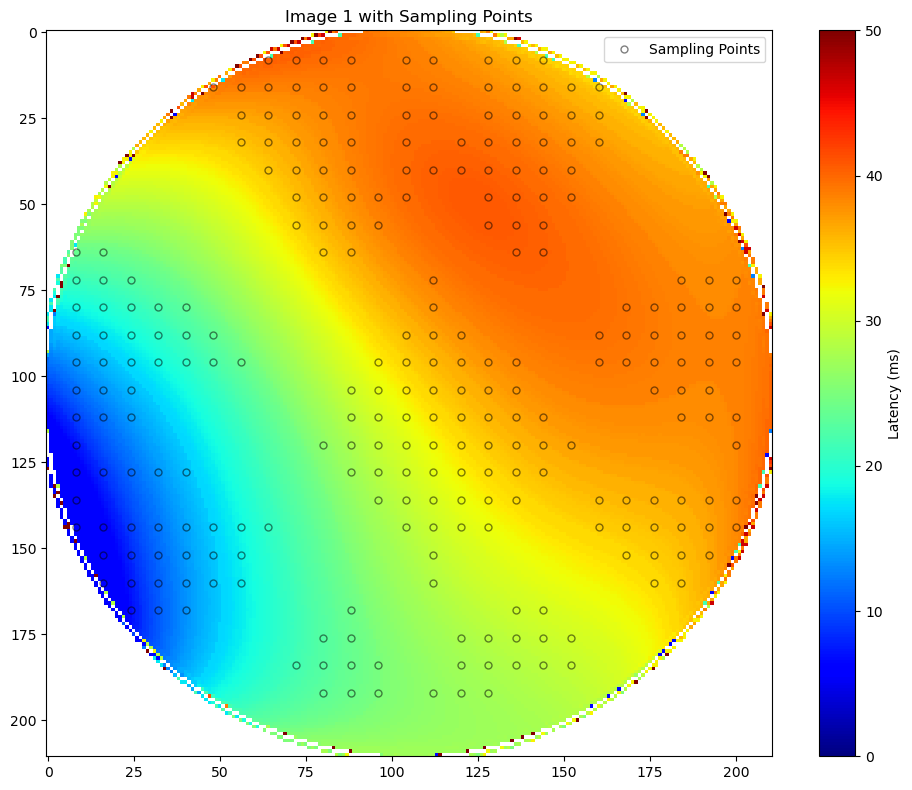

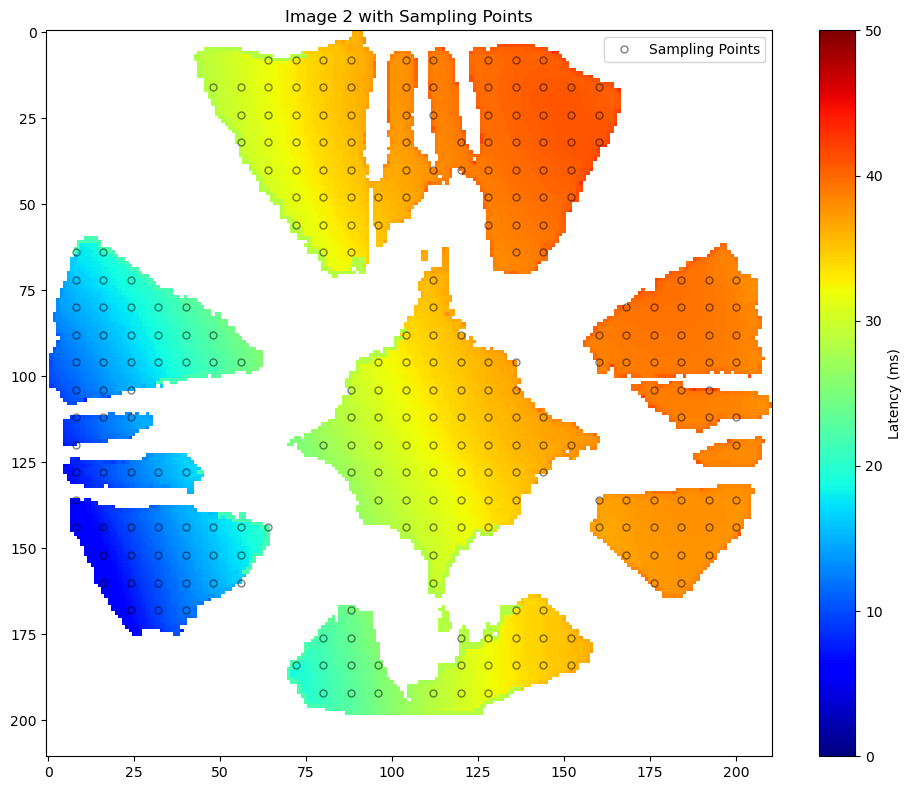


Detailed Statistics for Image 1 vs Image 2:
--------------------------------------------------
Correlation Analysis:
  Pearson Correlation (r) = 0.964
  P-value = 2.34e-152

Error Metrics:
  Root Mean Square Error = 2.62 ms
  Mean Absolute Error = 1.83 ms

Accuracy Thresholds:
  Within ±1ms: 49.2%
  Within ±2ms: 66.4%
  Within ±5ms: 93.5%


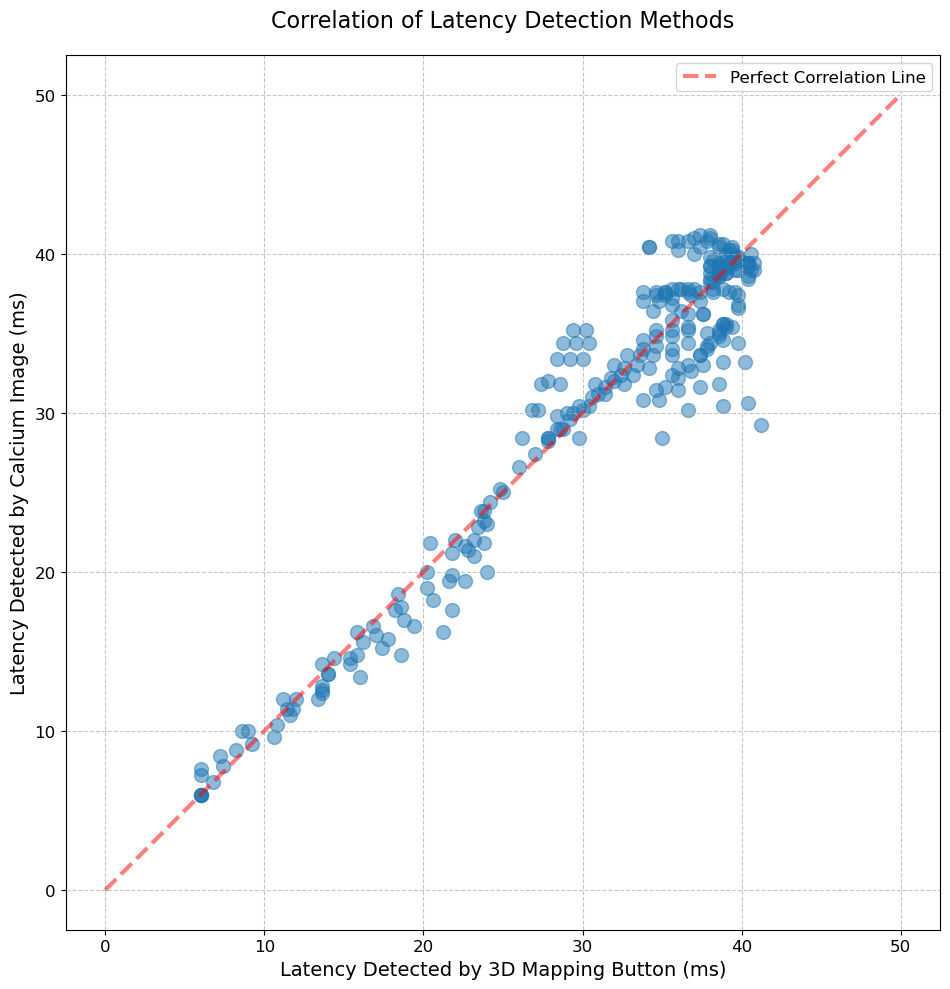

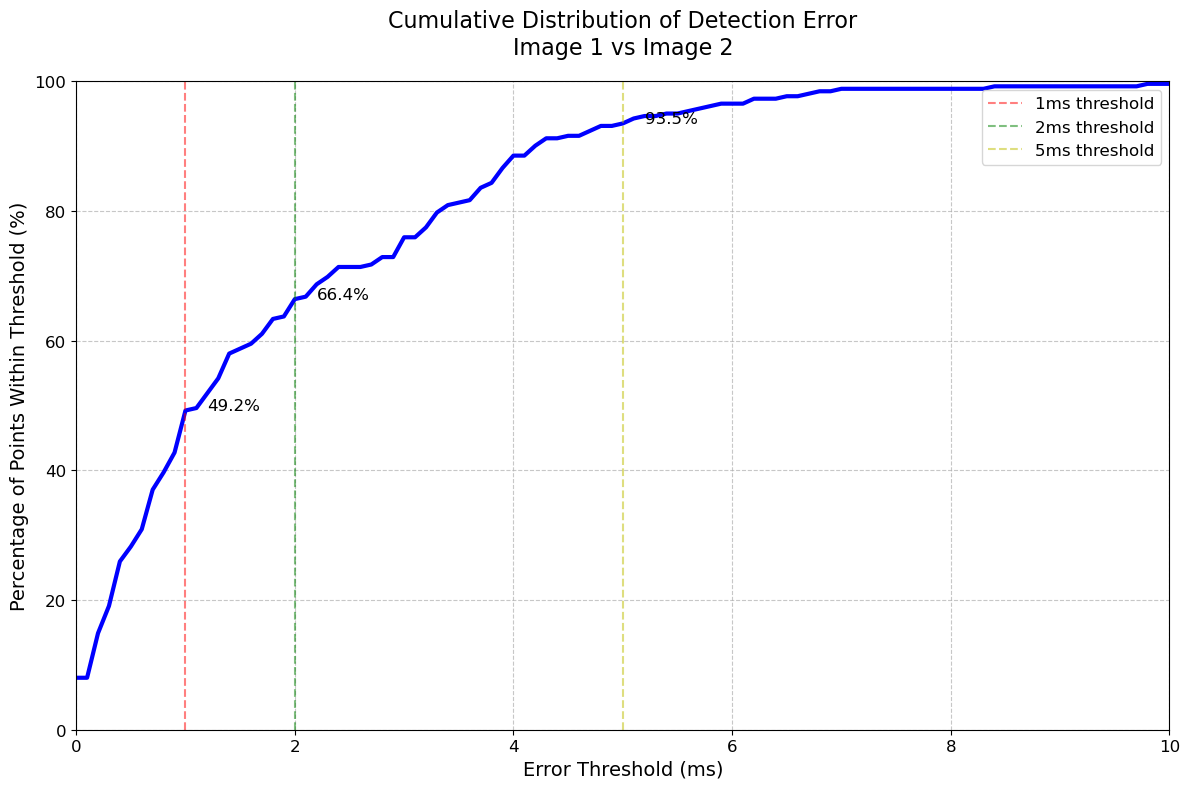


Analyzing Image 2 vs Image 3...


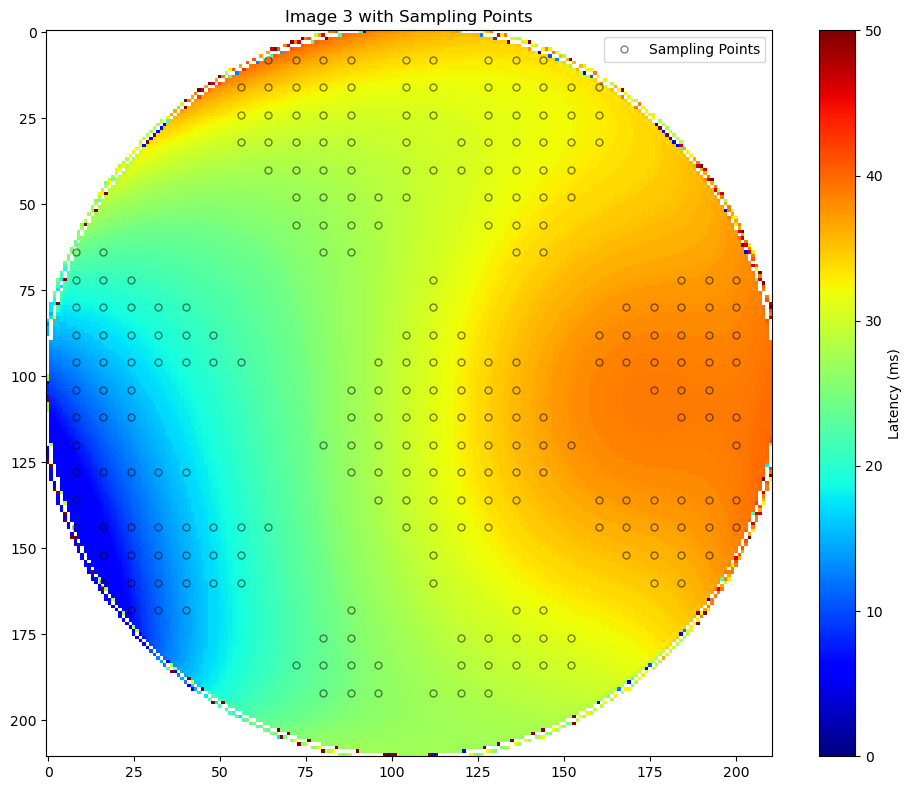

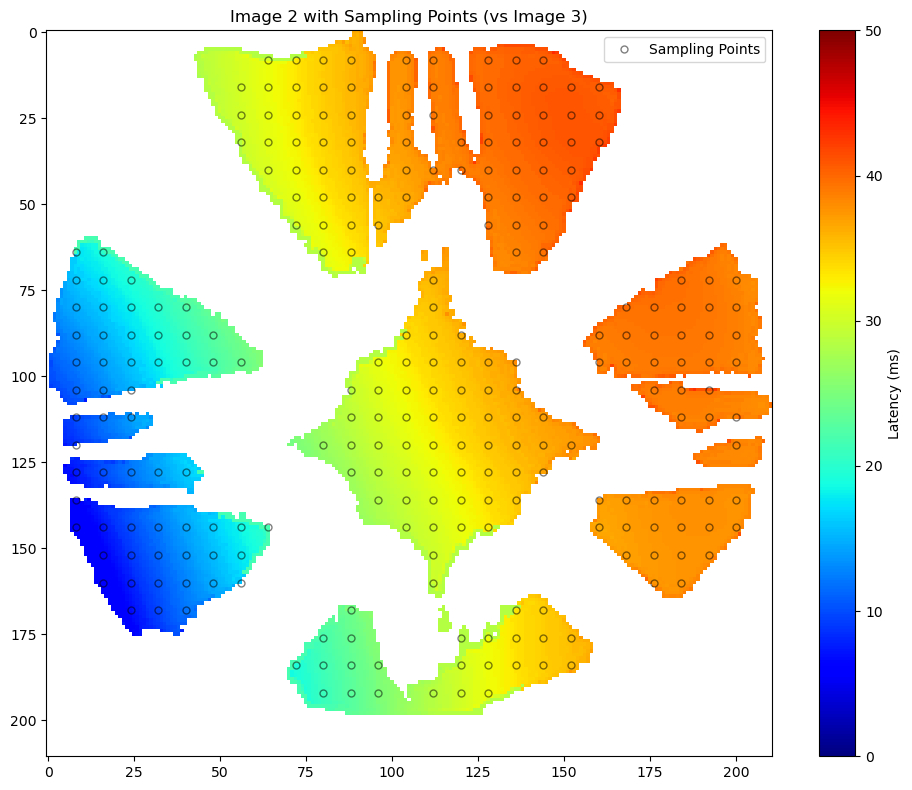


Detailed Statistics for Image 2 vs Image 3:
--------------------------------------------------
Correlation Analysis:
  Pearson Correlation (r) = 0.945
  P-value = 1.10e-127

Error Metrics:
  Root Mean Square Error = 3.82 ms
  Mean Absolute Error = 2.72 ms

Accuracy Thresholds:
  Within ±1ms: 36.8%
  Within ±2ms: 57.1%
  Within ±5ms: 78.5%


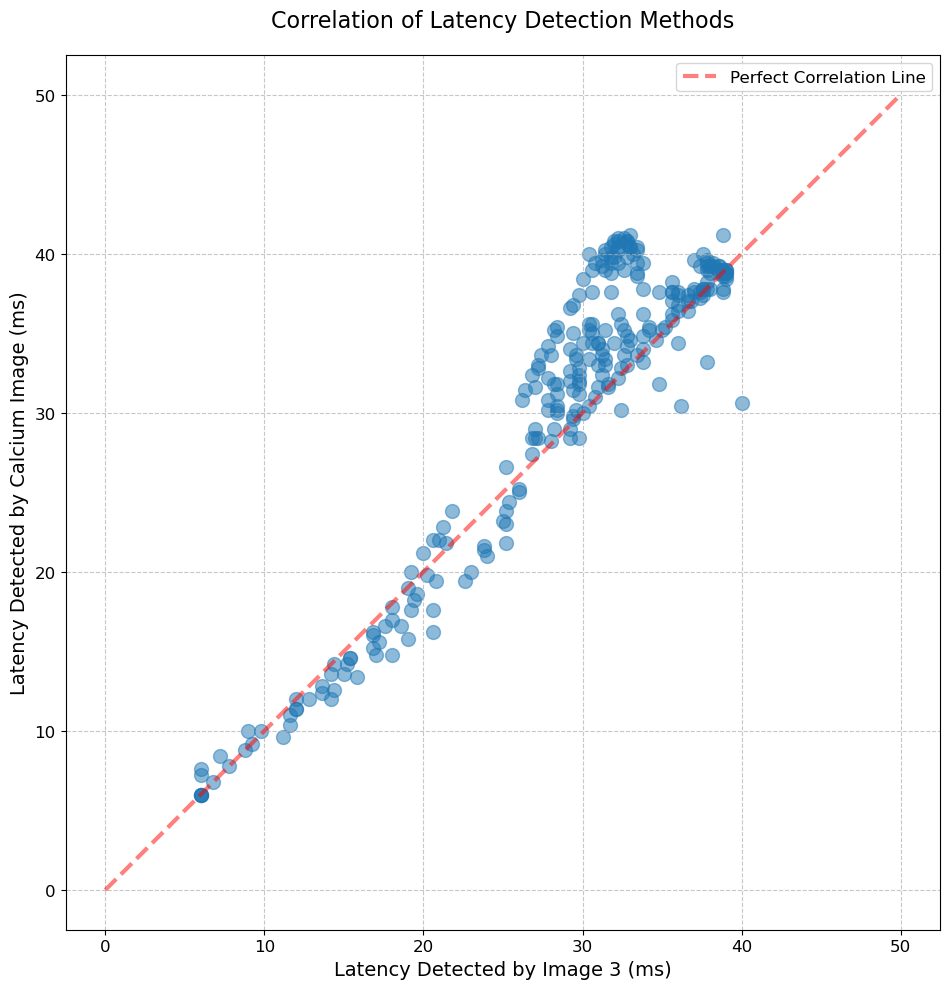

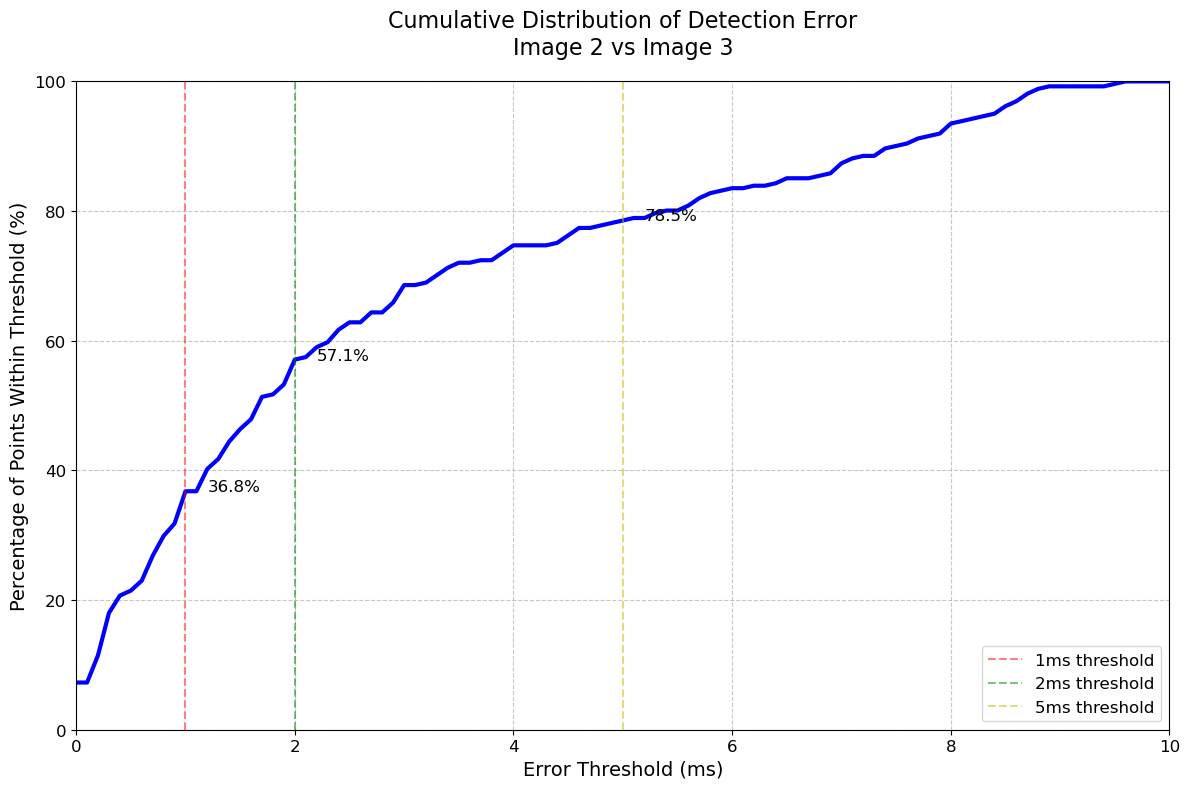


Analyzing Mean(Image1,Image3) vs Image 2...


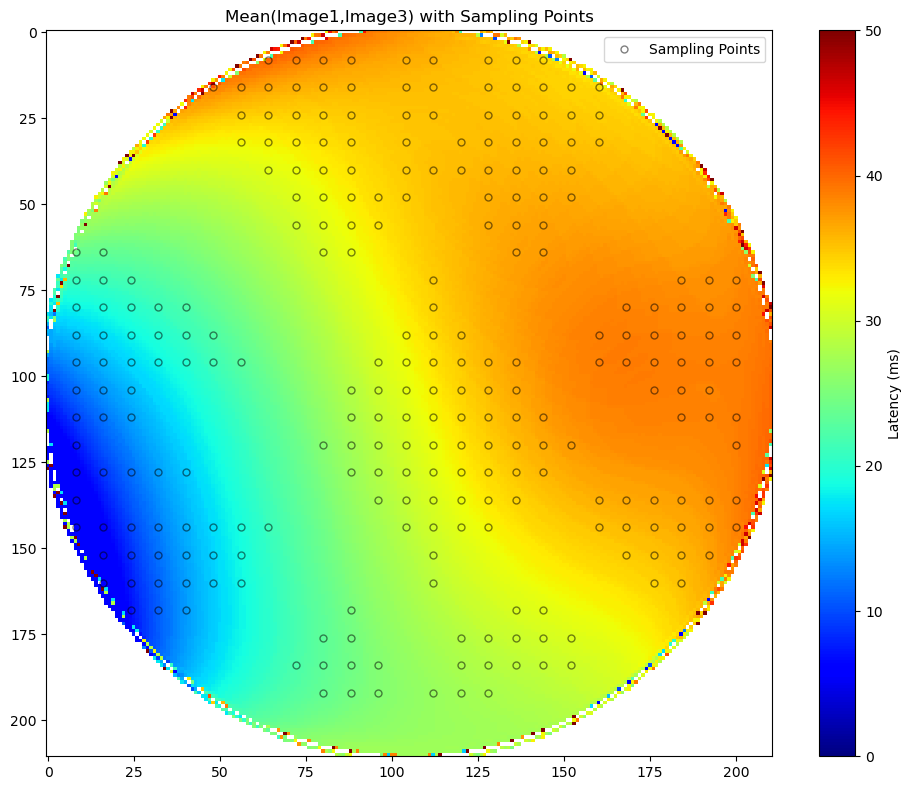

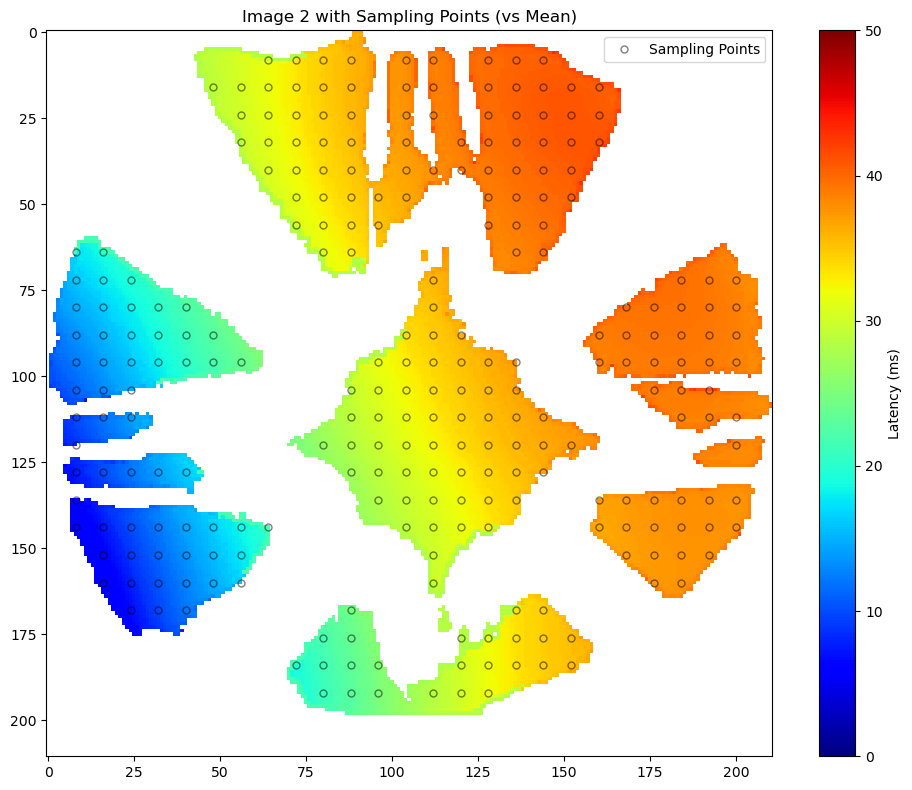


Detailed Statistics for Mean(Image1,Image3) vs Image 2:
--------------------------------------------------
Correlation Analysis:
  Pearson Correlation (r) = 0.970
  P-value = 1.28e-161

Error Metrics:
  Root Mean Square Error = 2.57 ms
  Mean Absolute Error = 1.77 ms

Accuracy Thresholds:
  Within ±1ms: 47.3%
  Within ±2ms: 69.5%
  Within ±5ms: 93.1%


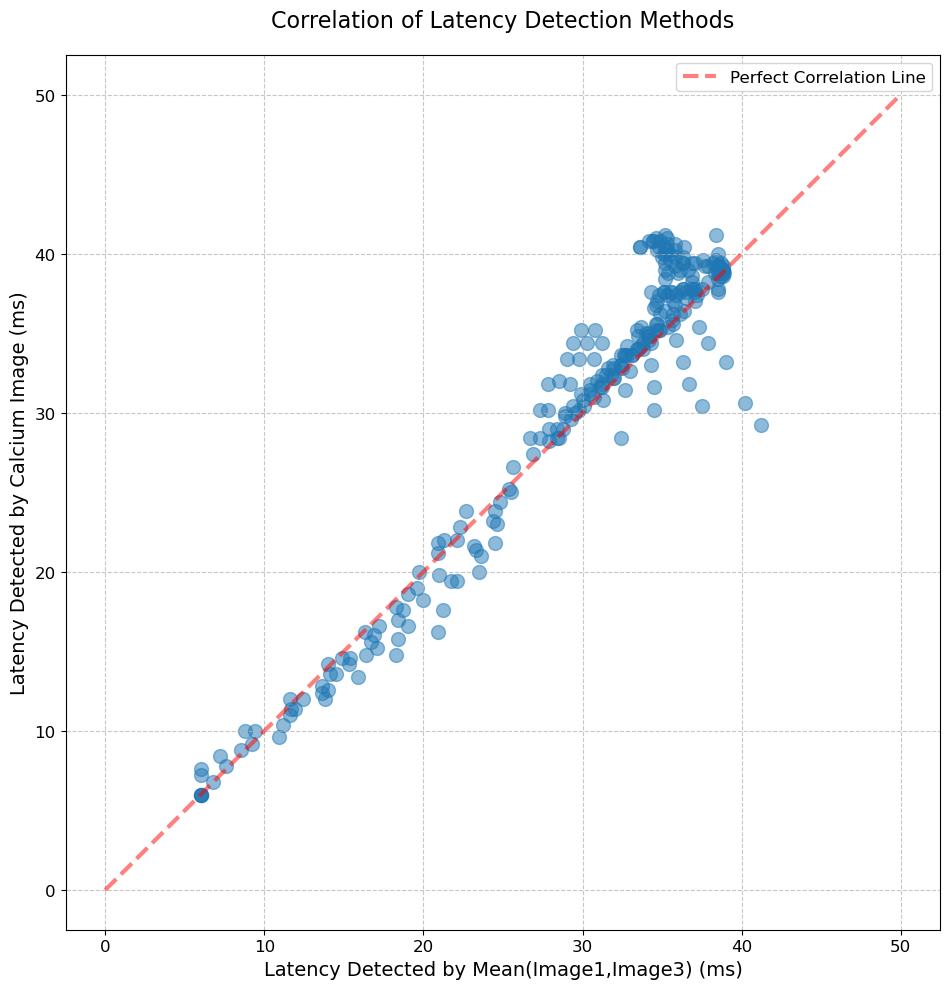

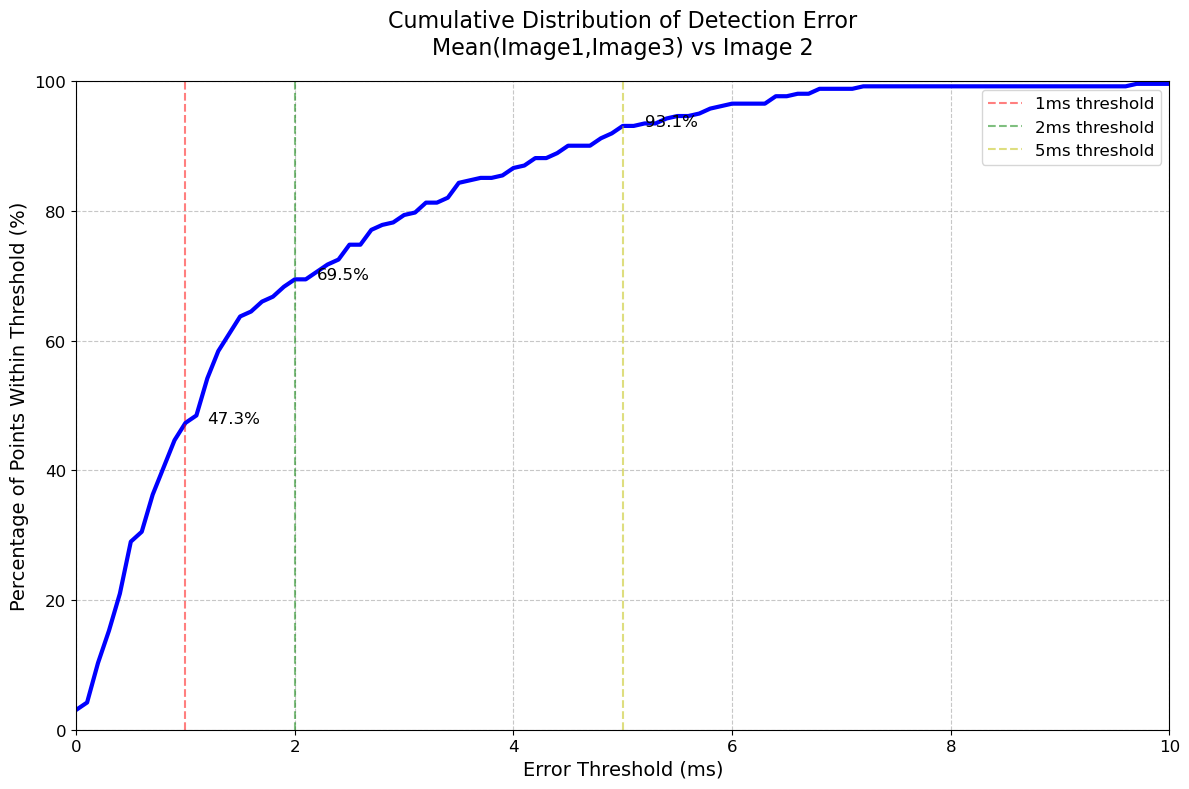

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.metrics import mean_squared_error, mean_absolute_error

def load_processed_data():
    data1 = np.load('data/extracted_data1.npy')
    data2 = np.load('data/extracted_data2.npy')
    data3 = np.load('data/extracted_data3.npy')
    return data1/2, data2/2, data3/2

def sample_and_pair_data(data1, data2, sampling_rate=SAMPLING_RATE):
    height, width = data1.shape
    values1 = []
    values2 = []
    sampling_points = []  # Store the coordinates of sampling points
    
    for i in range(0, height, sampling_rate):
        for j in range(0, width, sampling_rate):
            val1 = data1[i, j]
            val2 = data2[i, j]
            
            if not (np.isnan(val1) or np.isnan(val2)):
                values1.append(val1)
                values2.append(val2)
                sampling_points.append((i, j))  # Store the coordinates
    
    return np.array(values1), np.array(values2), sampling_points

def plot_isochronal_map_with_points(data, sampling_points, title):
    plt.figure(figsize=(10, 8))
    
    # Create custom colormap that makes NaN values white
    cmap = plt.cm.jet.copy()
    cmap.set_bad('white')
    
    # Plot the isochronal map
    plt.imshow(data, cmap=cmap, vmin=0, vmax=50)
    plt.colorbar(label='Latency (ms)')
    
    # Plot sampling points as hollow circles
    if sampling_points:
        points = np.array(sampling_points)
        plt.plot(points[:, 1], points[:, 0], 'o', 
                markerfacecolor='none', markeredgecolor='black', 
                markeredgewidth=1, markersize=5, alpha=0.5,
                label='Sampling Points')
    
    plt.title(title)
    plt.axis('on')  # Show axes to better visualize point locations
    plt.legend()
    plt.tight_layout()
    plt.show()

def calculate_statistics(values1, values2):
    correlation, p_value = stats.pearsonr(values1, values2)
    mse = mean_squared_error(values2, values1)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(values2, values1)
    
    diff = np.abs(values1 - values2)
    acc_1ms = np.mean(diff <= 1) * 100
    acc_2ms = np.mean(diff <= 2) * 100
    acc_5ms = np.mean(diff <= 5) * 100
    
    return {
        'correlation': correlation,
        'p_value': p_value,
        'mse': mse,
        'rmse': rmse,
        'mae': mae,
        'acc_1ms': acc_1ms,
        'acc_2ms': acc_2ms,
        'acc_5ms': acc_5ms
    }

def print_statistics(stats, comparison_name=""):
    print(f"\nDetailed Statistics for {comparison_name}:")
    print("-" * 50)
    print(f"Correlation Analysis:")
    print(f"  Pearson Correlation (r) = {stats['correlation']:.3f}")
    print(f"  P-value = {stats['p_value']:.2e}")
    print("\nError Metrics:")
    print(f"  Root Mean Square Error = {stats['rmse']:.2f} ms")
    print(f"  Mean Absolute Error = {stats['mae']:.2f} ms")
    print("\nAccuracy Thresholds:")
    print(f"  Within ±1ms: {stats['acc_1ms']:.1f}%")
    print(f"  Within ±2ms: {stats['acc_2ms']:.1f}%")
    print(f"  Within ±5ms: {stats['acc_5ms']:.1f}%")

def create_correlation_plot(values1, values2, title1, title2):
    plt.figure(figsize=(12, 10))
    
    plt.scatter(values1, values2, alpha=0.5, s=100)
    
    plt.xlabel(f'Latency Detected by {title1} (ms)', fontsize=14)
    plt.ylabel(f'Latency Detected by {title2} (ms)', fontsize=14)
    plt.title('Correlation of Latency Detection Methods', fontsize=16, pad=20)
    
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.xlim(0, 50)
    plt.ylim(0, 50)
    
    plt.plot([0, 50], [0, 50], 'r--', alpha=0.5, linewidth=3, label='Perfect Correlation Line')
    plt.legend(fontsize=12)
    plt.axis('square')
    
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    
    plt.tight_layout()
    plt.show()

def create_cumulative_accuracy_plot(values1, values2, comparison_name=""):
    differences = np.abs(values1 - values2)
    thresholds = np.arange(0, 10.1, 0.1)
    percentages = []
    
    for thresh in thresholds:
        percent = np.mean(differences <= thresh) * 100
        percentages.append(percent)
    
    plt.figure(figsize=(12, 8))
    plt.plot(thresholds, percentages, 'b-', linewidth=3)
    
    plt.xlabel('Error Threshold (ms)', fontsize=14)
    plt.ylabel('Percentage of Points Within Threshold (%)', fontsize=14)
    plt.title(f'Cumulative Distribution of Detection Error\n{comparison_name}', fontsize=16, pad=20)
    
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.xlim(0, 10)
    plt.ylim(0, 100)
    
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    
    for thresh, style in [(1, 'r--'), (2, 'g--'), (5, 'y--')]:
        plt.axvline(x=thresh, linestyle='--', color=style[0], alpha=0.5,
                   label=f'{thresh}ms threshold')
        y_val = np.interp(thresh, thresholds, percentages)
        plt.text(thresh+0.2, y_val, f'{y_val:.1f}%', fontsize=12)
    
    plt.legend(fontsize=12)
    plt.tight_layout()
    plt.show()

def main():
    print("Loading and scaling processed data...")
    data1, data2, data3 = load_processed_data()
    
    # Calculate mean of image1 and image3
    data_mean13 = np.nanmean(np.stack([data1, data3]), axis=0)
    
    # Original comparison (Image 1 vs 2)
    print("\nAnalyzing Image 1 vs Image 2...")

    values1_2, values2, sampling_points_1_2 = sample_and_pair_data(data1, data2, sampling_rate=SAMPLING_RATE)
    stats1_2 = calculate_statistics(values1_2, values2)
    
    # Plot isochronal maps with sampling points
    plot_isochronal_map_with_points(data1, sampling_points_1_2, "Image 1 with Sampling Points")
    plot_isochronal_map_with_points(data2, sampling_points_1_2, "Image 2 with Sampling Points")
    
    print_statistics(stats1_2, "Image 1 vs Image 2")
    create_correlation_plot(values1_2, values2, "3D Mapping Button", "Calcium Image")
    create_cumulative_accuracy_plot(values1_2, values2, "Image 1 vs Image 2")
    
    # Image 2 vs Image 3
    print("\nAnalyzing Image 2 vs Image 3...")
    values3_2, values2_3, sampling_points_2_3 = sample_and_pair_data(data3, data2, sampling_rate=SAMPLING_RATE)
    stats2_3 = calculate_statistics(values3_2, values2_3)
    
    # Plot isochronal maps with sampling points
    plot_isochronal_map_with_points(data3, sampling_points_2_3, "Image 3 with Sampling Points")
    plot_isochronal_map_with_points(data2, sampling_points_2_3, "Image 2 with Sampling Points (vs Image 3)")
    
    print_statistics(stats2_3, "Image 2 vs Image 3")
    create_correlation_plot(values3_2, values2_3, "Image 3", "Calcium Image")
    create_cumulative_accuracy_plot(values3_2, values2_3, "Image 2 vs Image 3")
    
    # Mean(Image1,Image3) vs Image 2
    print("\nAnalyzing Mean(Image1,Image3) vs Image 2...")
    values_mean13, values2_mean, sampling_points_mean = sample_and_pair_data(data_mean13, data2, sampling_rate=SAMPLING_RATE)
    stats_mean = calculate_statistics(values_mean13, values2_mean)
    
    # Plot isochronal maps with sampling points
    plot_isochronal_map_with_points(data_mean13, sampling_points_mean, "Mean(Image1,Image3) with Sampling Points")
    plot_isochronal_map_with_points(data2, sampling_points_mean, "Image 2 with Sampling Points (vs Mean)")
    
    print_statistics(stats_mean, "Mean(Image1,Image3) vs Image 2")
    create_correlation_plot(values_mean13, values2_mean, "Mean(Image1,Image3)", "Calcium Image")
    create_cumulative_accuracy_plot(values_mean13, values2_mean, "Mean(Image1,Image3) vs Image 2")
    
    return {
        'image1_vs_2': (values1_2, values2, stats1_2, sampling_points_1_2),
        'image2_vs_3': (values3_2, values2_3, stats2_3, sampling_points_2_3),
        'mean_vs_2': (values_mean13, values2_mean, stats_mean, sampling_points_mean)
    }

if __name__ == "__main__":
    results = main()

Loading and scaling processed data...

Analyzing Image 1 vs Image 2...
(211, 211)
(211, 211)


D:\temp\ipykernel_29280\994174585.py:376: RuntimeWarning: Mean of empty slice
  data_mean13 = np.nanmean(np.stack([data1, data3]), axis=0)


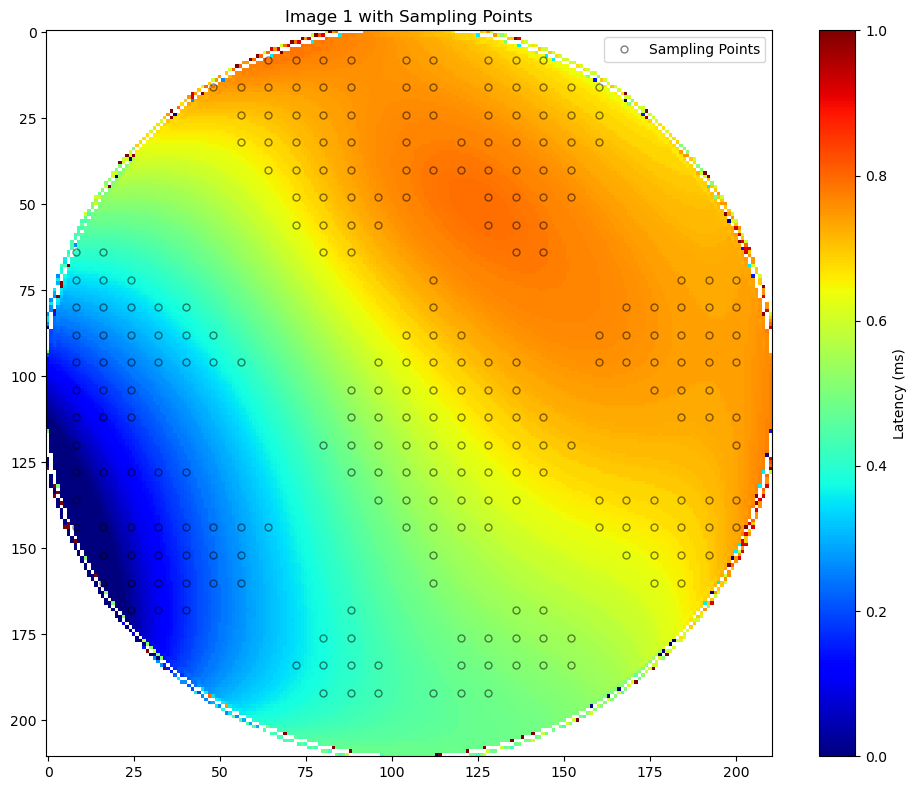

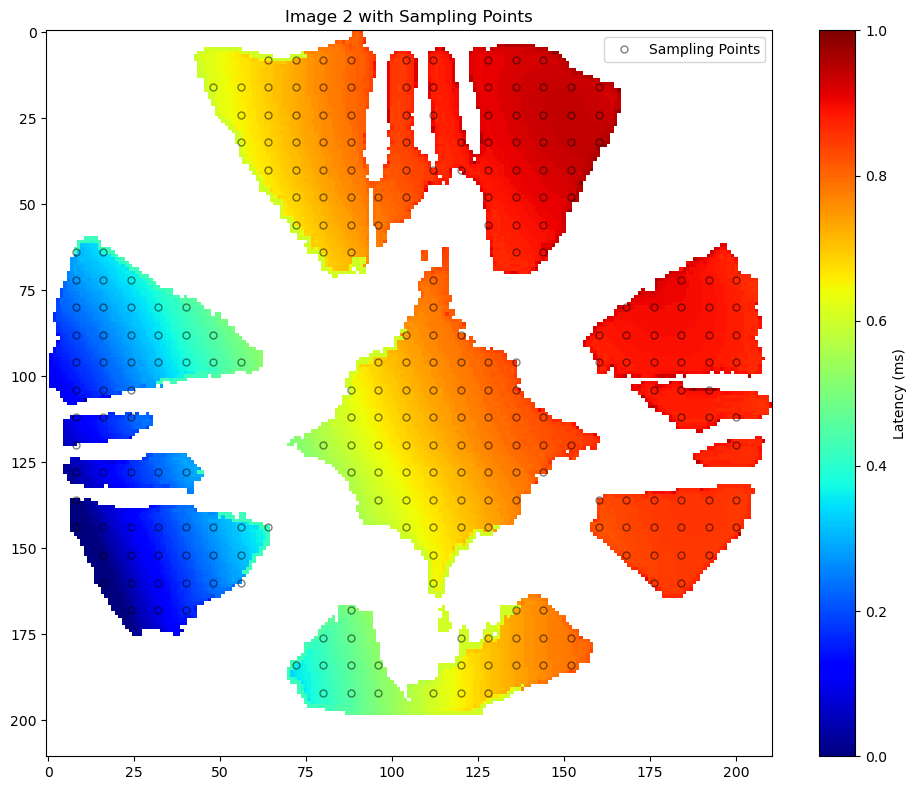


Detailed Statistics for Image 1 vs Image 2:
--------------------------------------------------
Correlation Analysis:
  Pearson Correlation (r) = 0.964
  P-value = 2.34e-152
  Log-transformed P-value = 151.6

Error Metrics:
  Root Mean Square Error = 0.122 ms
  Mean Absolute Error = 0.101 ms
  Standard Deviation of Error = 0.068 ms

Accuracy Thresholds:
  Within ±1ms: 32.4%
  Within ±2ms: 47.7%
  Within ±5ms: 90.8%


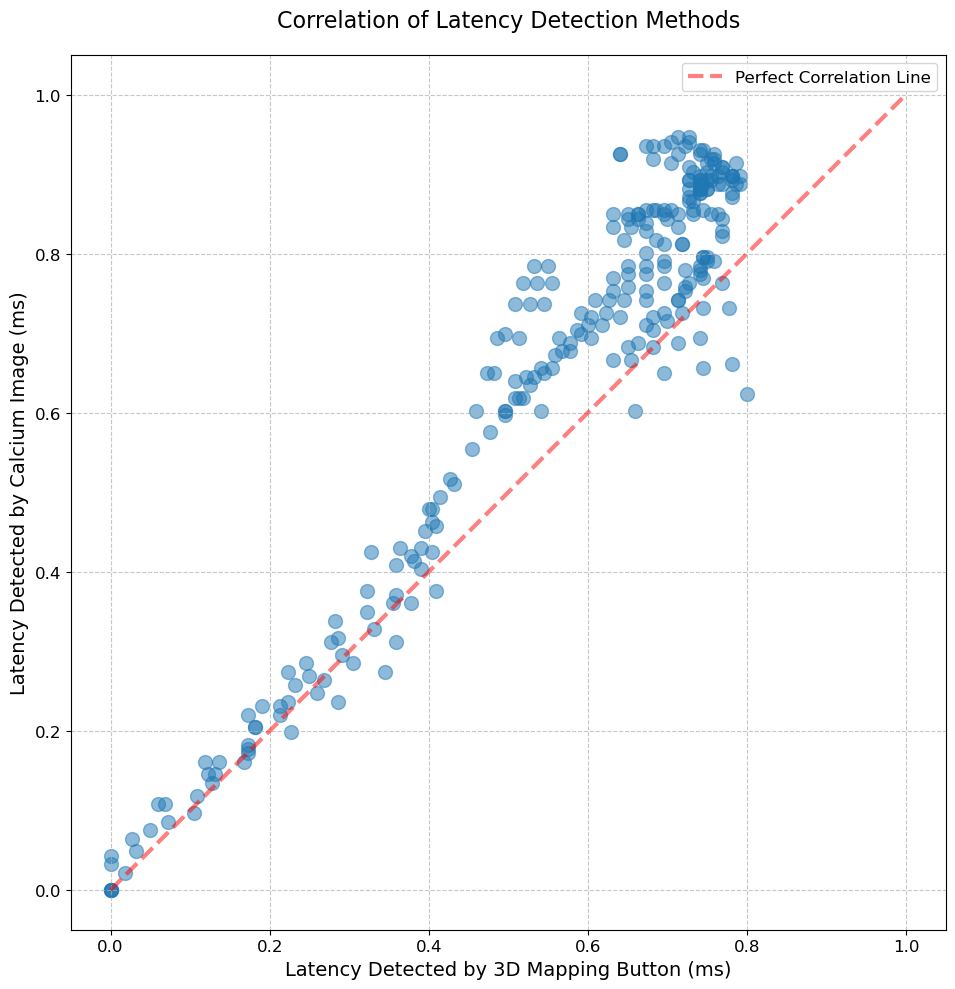

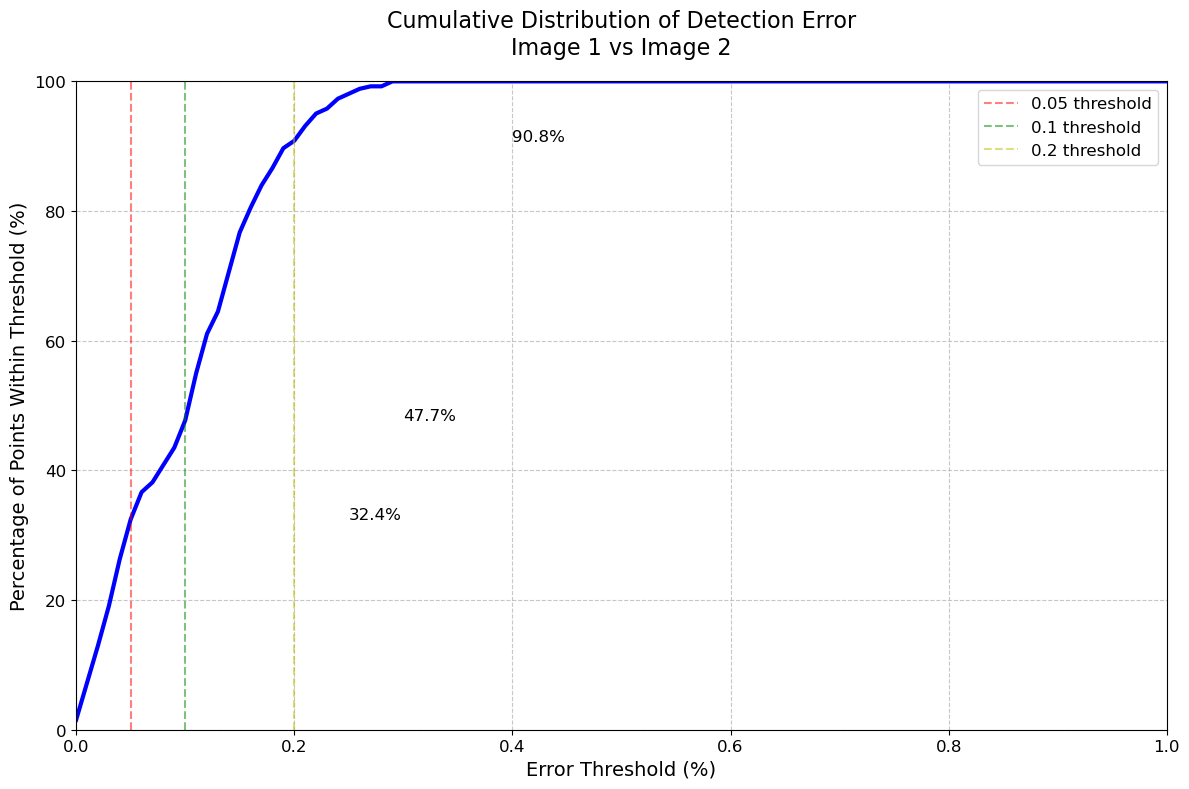


Analyzing Image 2 vs Image 3...
(211, 211)
(211, 211)


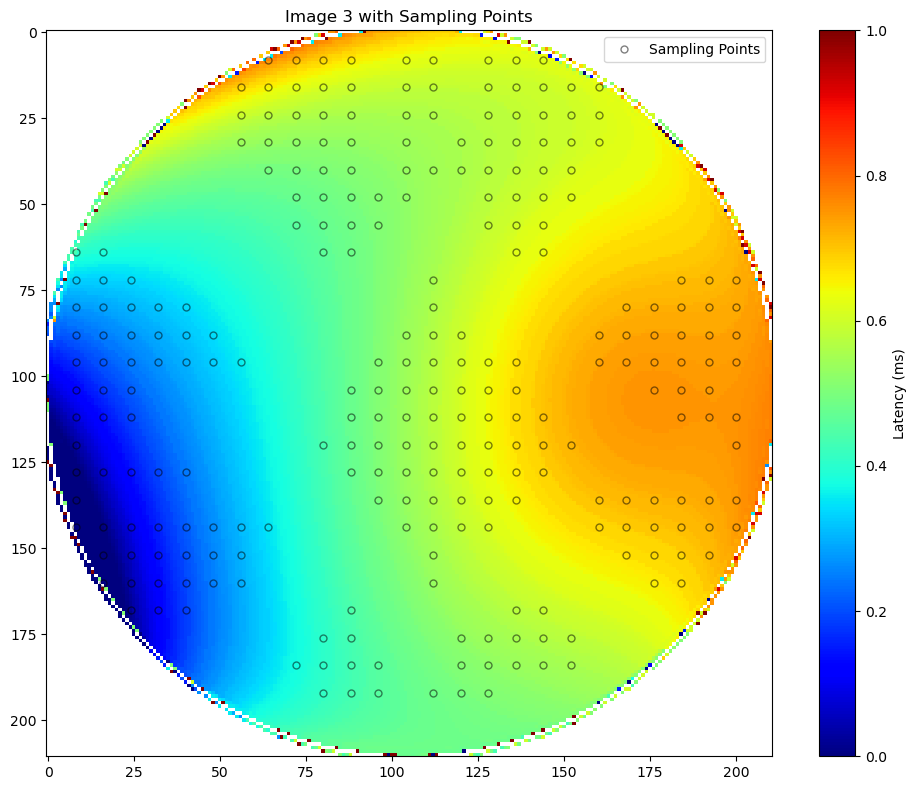

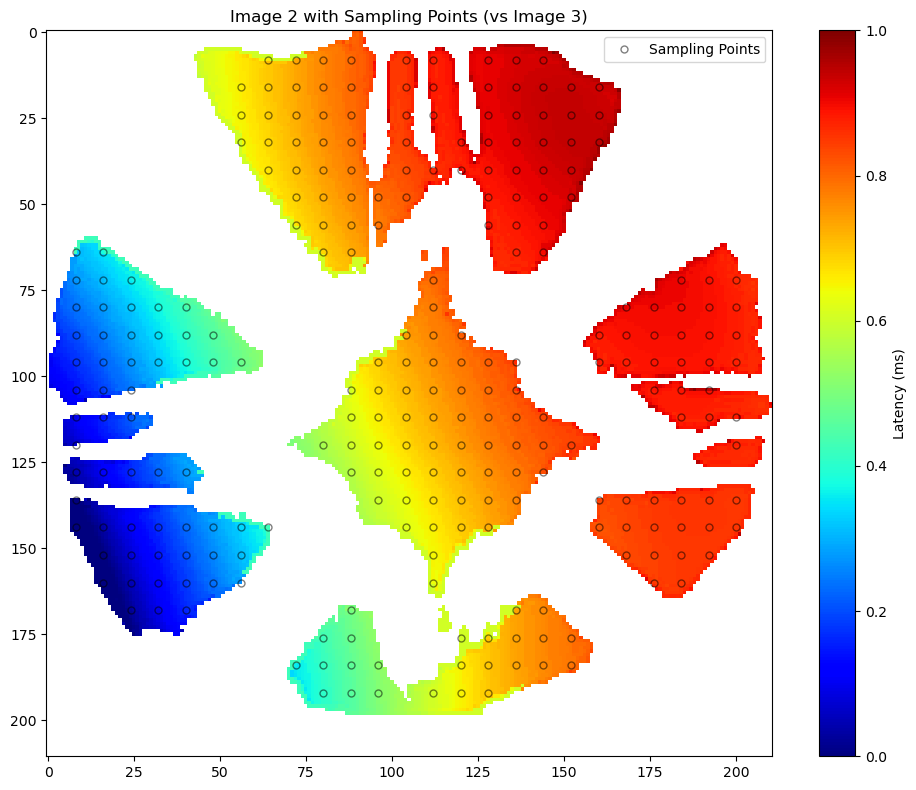


Detailed Statistics for Image 2 vs Image 3:
--------------------------------------------------
Correlation Analysis:
  Pearson Correlation (r) = 0.945
  P-value = 1.10e-127
  Log-transformed P-value = 127.0

Error Metrics:
  Root Mean Square Error = 0.178 ms
  Mean Absolute Error = 0.147 ms
  Standard Deviation of Error = 0.099 ms

Accuracy Thresholds:
  Within ±1ms: 23.0%
  Within ±2ms: 29.9%
  Within ±5ms: 73.6%


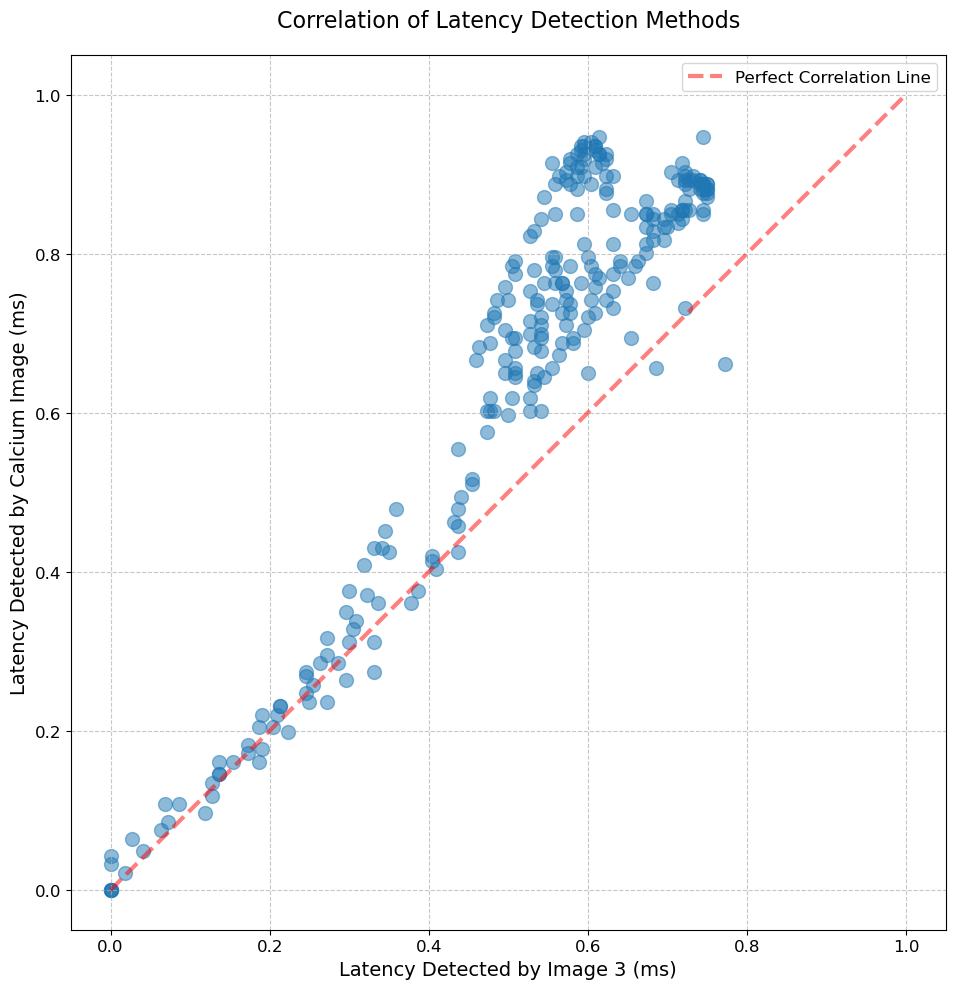

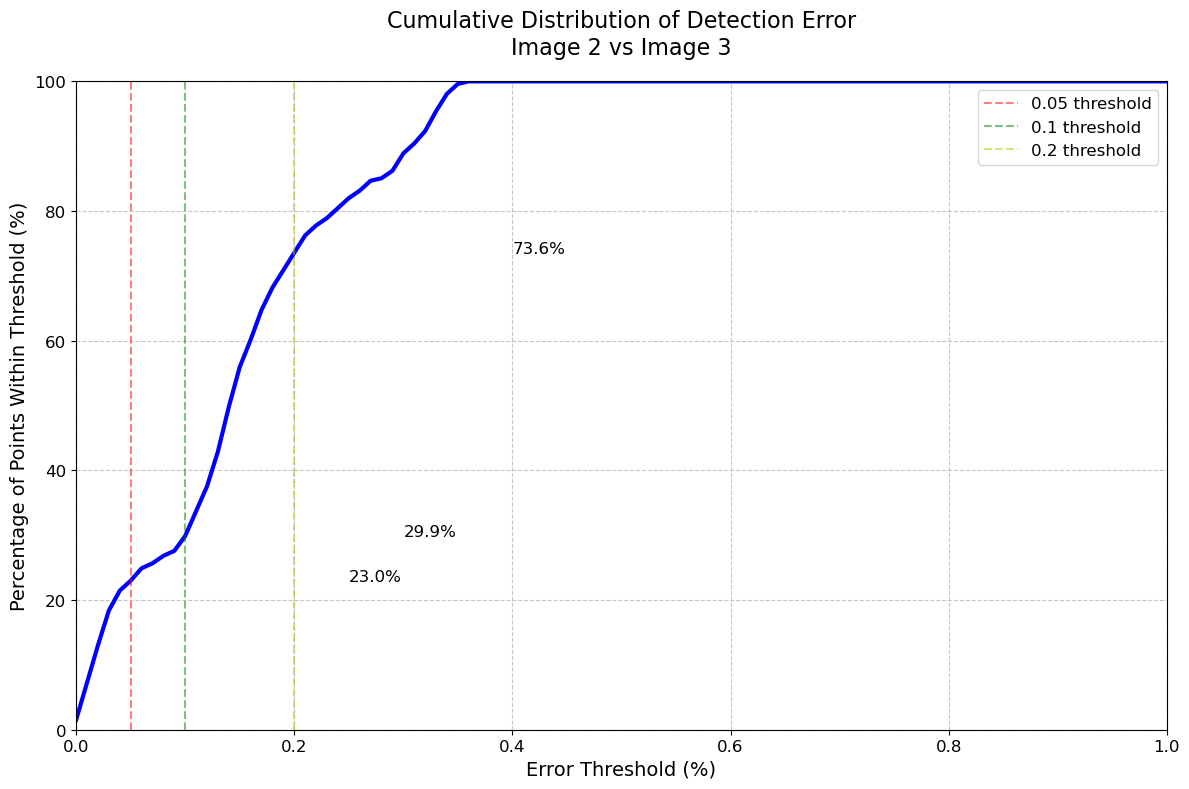


Analyzing Mean(Image1,Image3) vs Image 2...
(211, 211)
(211, 211)


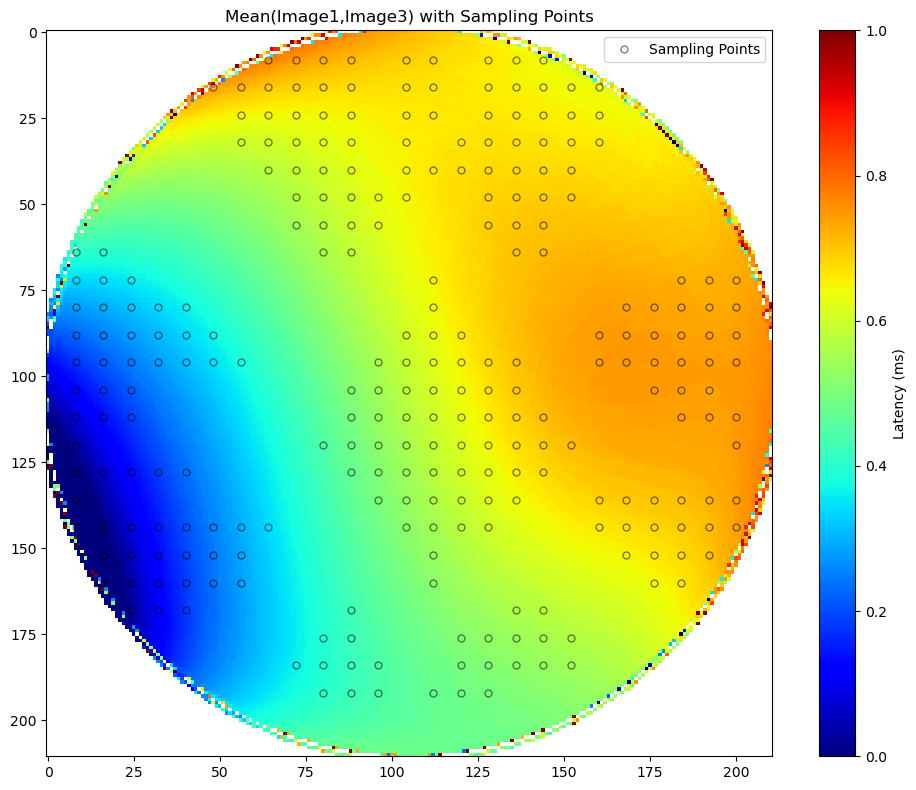

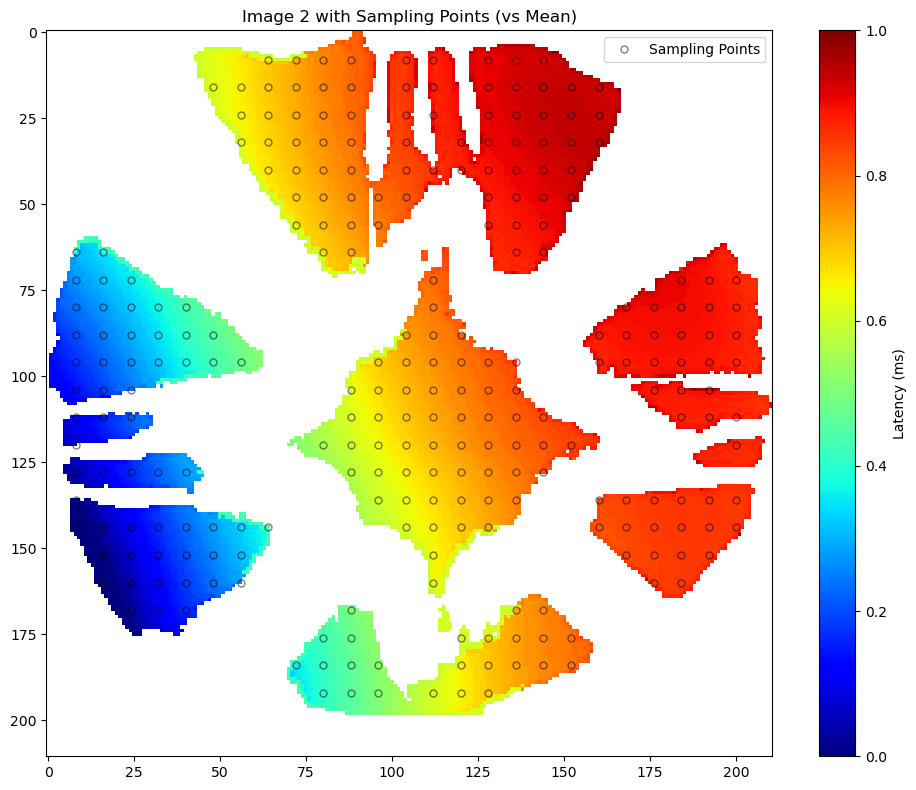


Detailed Statistics for Mean(Image1,Image3) vs Image 2:
--------------------------------------------------
Correlation Analysis:
  Pearson Correlation (r) = 0.970
  P-value = 1.28e-161
  Log-transformed P-value = 160.9

Error Metrics:
  Root Mean Square Error = 0.145 ms
  Mean Absolute Error = 0.123 ms
  Standard Deviation of Error = 0.076 ms

Accuracy Thresholds:
  Within ±1ms: 24.4%
  Within ±2ms: 32.4%
  Within ±5ms: 85.1%


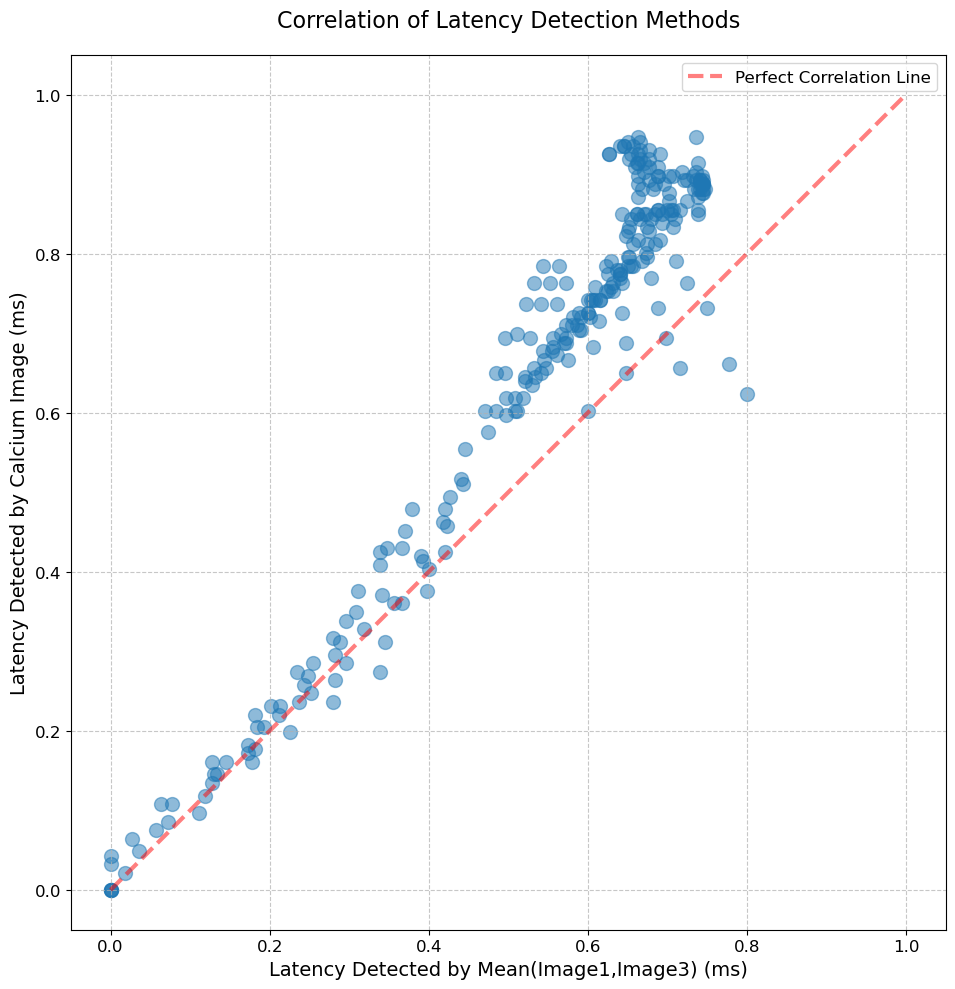

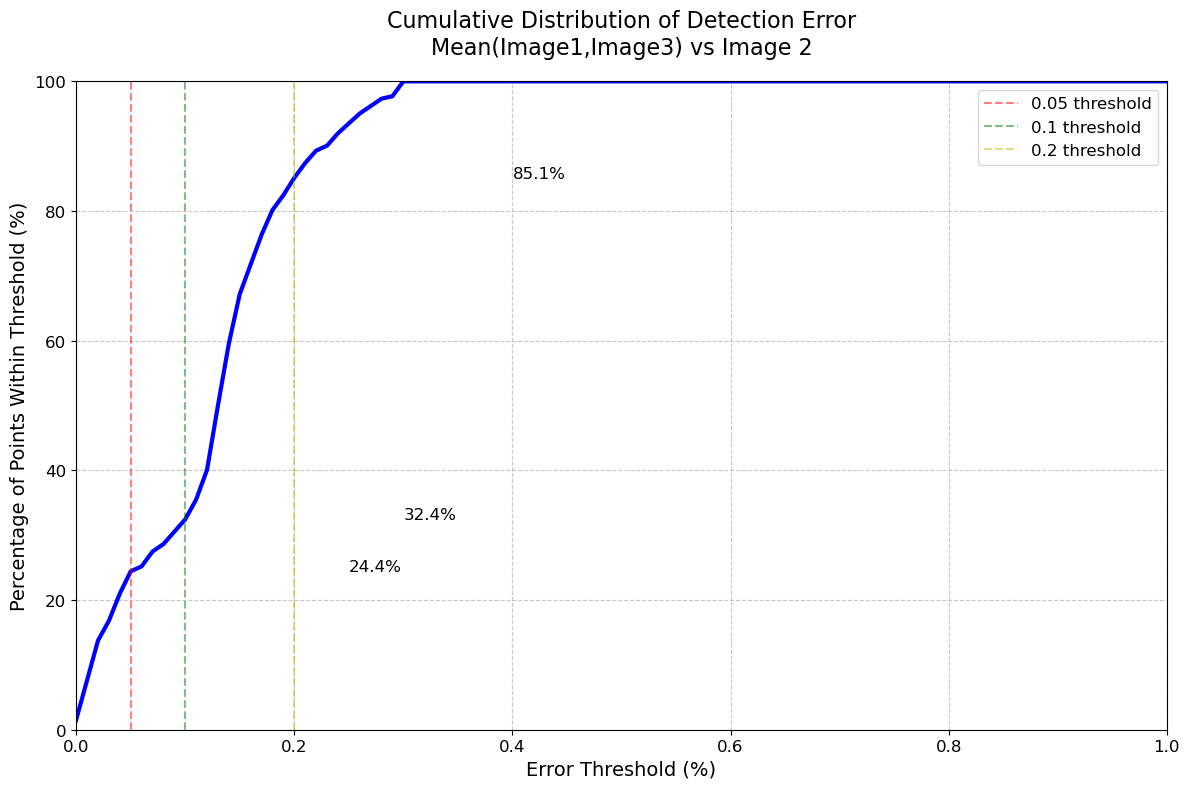

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.metrics import mean_squared_error, mean_absolute_error

def normalize(data):
    # Ignore NaN values in min and max calculations
    min_val = np.nanmin(data)
    max_val = np.nanmax(data)
    return (data - min_val) / (max_val - min_val)

def load_processed_data():
    data1 = np.load('data/extracted_data1.npy')
    data2 = np.load('data/extracted_data2.npy')
    data3 = np.load('data/extracted_data3.npy')
    print(data1)
    data1 = normalize(data1)
    data2 = normalize(data2)
    data3 = normalize(data3)
    print(data1)
    return data1, data2, data3

def sample_and_pair_data(data1, data2, sampling_rate=SAMPLING_RATE):
    height, width = data1.shape
    values1 = []
    values2 = []
    sampling_points = []  # Store the coordinates of sampling points
    
    for i in range(0, height, sampling_rate):
        for j in range(0, width, sampling_rate):
            val1 = data1[i, j]
            val2 = data2[i, j]
            
            if not (np.isnan(val1) or np.isnan(val2)):
                values1.append(val1)
                values2.append(val2)
                sampling_points.append((i, j))  # Store the coordinates
    
    return np.array(values1), np.array(values2), sampling_points

def plot_isochronal_map_with_points(data, sampling_points, title):
    plt.figure(figsize=(10, 8))
    
    # Create custom colormap that makes NaN values white
    cmap = plt.cm.jet.copy()
    cmap.set_bad('white')
    
    # Plot the isochronal map
    plt.imshow(data, cmap=cmap, vmin=0, vmax=1)
    plt.colorbar(label='Latency (ms)')
    
    # Plot sampling points as hollow circles
    if sampling_points:
        points = np.array(sampling_points)
        plt.plot(points[:, 1], points[:, 0], 'o', 
                markerfacecolor='none', markeredgecolor='black', 
                markeredgewidth=1, markersize=5, alpha=0.5,
                label='Sampling Points')
    
    plt.title(title)
    plt.axis('on')  # Show axes to better visualize point locations
    plt.legend()
    plt.tight_layout()
    plt.show()

def calculate_statistics(values1, values2):
    correlation, p_value = stats.pearsonr(values1, values2)
    mse = mean_squared_error(values2, values1)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(values2, values1)
    
    diff = np.abs(values1 - values2)
    acc_1ms = np.mean(diff <= 1) * 100
    acc_2ms = np.mean(diff <= 2) * 100
    acc_5ms = np.mean(diff <= 5) * 100
    
    return {
        'correlation': correlation,
        'p_value': p_value,
        'mse': mse,
        'rmse': rmse,
        'mae': mae,
        'acc_1ms': acc_1ms,
        'acc_2ms': acc_2ms,
        'acc_5ms': acc_5ms
    }

def print_statistics(stats, comparison_name=""):
    print(f"\nDetailed Statistics for {comparison_name}:")
    print("-" * 50)
    print(f"Correlation Analysis:")
    print(f"  Pearson Correlation (r) = {stats['correlation']:.3f}")
    print(f"  P-value = {stats['p_value']:.2e}")
    print("\nError Metrics:")
    print(f"  Root Mean Square Error = {stats['rmse']:.2f} ms")
    print(f"  Mean Absolute Error = {stats['mae']:.2f} ms")
    print("\nAccuracy Thresholds:")
    print(f"  Within ±5%: {stats['acc_1ms']*100:.1f}%")
    print(f"  Within ±10%: {stats['acc_2ms']*100:.1f}%")
    print(f"  Within ±20%: {stats['acc_5ms']*100:.1f}%")

def create_correlation_plot(values1, values2, title1, title2):
    plt.figure(figsize=(12, 10))
    
    plt.scatter(values1, values2, alpha=0.5, s=100)
    
    plt.xlabel(f'Latency Detected by {title1} (ms)', fontsize=14)
    plt.ylabel(f'Latency Detected by {title2} (ms)', fontsize=14)
    plt.title('Correlation of Latency Detection Methods', fontsize=16, pad=20)
    
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    
    plt.plot([0, 1], [0, 1], 'r--', alpha=0.5, linewidth=3, label='Perfect Correlation Line')
    plt.legend(fontsize=12)
    plt.axis('square')
    
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    
    plt.tight_layout()
    plt.show()

def create_cumulative_accuracy_plot(values1, values2, comparison_name=""):
    differences = np.abs(values1 - values2)
    thresholds = np.arange(0, 10.1, 0.1)
    percentages = []
    
    for thresh in thresholds:
        percent = np.mean(differences <= thresh) * 100
        percentages.append(percent)
    
    plt.figure(figsize=(12, 8))
    plt.plot(thresholds, percentages, 'b-', linewidth=3)
    
    plt.xlabel('Error Threshold (ms)', fontsize=14)
    plt.ylabel('Percentage of Points Within Threshold (%)', fontsize=14)
    plt.title(f'Cumulative Distribution of Detection Error\n{comparison_name}', fontsize=16, pad=20)
    
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.xlim(0, 10)
    plt.ylim(0, 100)
    
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    
    for thresh, style in [(1, 'r--'), (2, 'g--'), (5, 'y--')]:
        plt.axvline(x=thresh, linestyle='--', color=style[0], alpha=0.5,
                   label=f'{thresh}ms threshold')
        y_val = np.interp(thresh, thresholds, percentages)
        plt.text(thresh+0.2, y_val, f'{y_val:.1f}%', fontsize=12)
    
    plt.legend(fontsize=12)
    plt.tight_layout()
    plt.show()

import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.metrics import mean_squared_error, mean_absolute_error

def normalize(data):
    # Ignore NaN values in min and max calculations
    min_val = np.nanmin(data)
    max_val = np.nanmax(data)
    return (data - min_val) / (max_val - min_val)

def load_processed_data():
    data1 = np.load('data/extracted_data1.npy')
    data2 = np.load('data/extracted_data2.npy')
    data3 = np.load('data/extracted_data3.npy')

    data1 = normalize(data1)
    data2 = normalize(data2)
    data3 = normalize(data3)

    return data1, data2, data3

def sample_and_pair_data(data1, data2, sampling_rate=SAMPLING_RATE):
    height, width = data2.shape
    print(data1.shape)
    print(data2.shape)
    values1 = []
    values2 = []
    sampling_points = []  # Store the coordinates of sampling points
    
    for i in range(0, height, sampling_rate):
        for j in range(0, width, sampling_rate):
            val1 = data1[i, j]
            val2 = data2[i, j]
            
            if not (np.isnan(val1) or np.isnan(val2)):
                values1.append(val1)
                values2.append(val2)
                sampling_points.append((i, j))  # Store the coordinates
    
    return np.array(values1), np.array(values2), sampling_points

def plot_isochronal_map_with_points(data, sampling_points, title):
    plt.figure(figsize=(10, 8))
    
    # Create custom colormap that makes NaN values white
    cmap = plt.cm.jet.copy()
    cmap.set_bad('white')
    
    # Plot the isochronal map
    plt.imshow(data, cmap=cmap, vmin=0, vmax=1)
    plt.colorbar(label='Latency (ms)')
    
    # Plot sampling points as hollow circles
    if sampling_points:
        points = np.array(sampling_points)
        plt.plot(points[:, 1], points[:, 0], 'o', 
                markerfacecolor='none', markeredgecolor='black', 
                markeredgewidth=1, markersize=5, alpha=0.5,
                label='Sampling Points')
    
    plt.title(title)
    plt.axis('on')  # Show axes to better visualize point locations
    plt.legend()
    plt.tight_layout()
    plt.show()

def calculate_statistics(values1, values2):
    correlation, p_value = stats.pearsonr(values1, values2)
    mse = mean_squared_error(values2, values1)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(values2, values1)
    
    diff = np.abs(values1 - values2)
    acc_1ms = np.mean(diff <= 0.05) * 100
    acc_2ms = np.mean(diff <= 0.10) * 100
    acc_5ms = np.mean(diff <= 0.2) * 100
    
    return {
        'correlation': correlation,
        'p_value': p_value,
        'mse': mse,
        'rmse': rmse,
        'mae': mae,
        'acc_1ms': acc_1ms,
        'acc_2ms': acc_2ms,
        'acc_5ms': acc_5ms
    }

def print_statistics(stats, comparison_name=""):
    print(f"\nDetailed Statistics for {comparison_name}:")
    print("-" * 50)
    print(f"Correlation Analysis:")
    print(f"  Pearson Correlation (r) = {stats['correlation']:.3f}")
    print(f"  P-value = {stats['p_value']:.2e}")
    print("\nError Metrics:")
    print(f"  Root Mean Square Error = {stats['rmse']*100:.2f} %")
    print(f"  Mean Absolute Error = {stats['mae']*100:.2f} %")
    print("\nAccuracy Thresholds:")
    print(f"  Within ±5%: {stats['acc_1ms']:.1f}%")
    print(f"  Within ±10%: {stats['acc_2ms']:.1f}%")
    print(f"  Within ±20%: {stats['acc_5ms']:.1f}%")

def create_correlation_plot(values1, values2, title1, title2):
    plt.figure(figsize=(12, 10))
    
    plt.scatter(values1, values2, alpha=0.5, s=100)
    
    plt.xlabel(f'Latency Detected by {title1} (ms)', fontsize=14)
    plt.ylabel(f'Latency Detected by {title2} (ms)', fontsize=14)
    plt.title('Correlation of Latency Detection Methods', fontsize=16, pad=20)
    
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    
    plt.plot([0, 1], [0, 1], 'r--', alpha=0.5, linewidth=3, label='Perfect Correlation Line')
    plt.legend(fontsize=12)
    plt.axis('square')
    
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    
    plt.tight_layout()
    plt.show()

def create_cumulative_accuracy_plot(values1, values2, comparison_name=""):
    differences = np.abs(values1 - values2)
    thresholds = np.arange(0, 1.01, 0.01)
    percentages = []
    
    for thresh in thresholds:
        percent = np.mean(differences <= thresh) * 100
        percentages.append(percent)
    
    plt.figure(figsize=(12, 8))
    plt.plot(thresholds, percentages, 'b-', linewidth=3)
    
    plt.xlabel('Error Threshold (%)', fontsize=14)
    plt.ylabel('Percentage of Points Within Threshold (%)', fontsize=14)
    plt.title(f'Cumulative Distribution of Detection Error\n{comparison_name}', fontsize=16, pad=20)
    
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.xlim(0, 1)
    plt.ylim(0, 100)
    
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    
    for thresh, style in [(0.05, 'r--'), (0.10, 'g--'), (0.20, 'y--')]:
        plt.axvline(x=thresh, linestyle='--', color=style[0], alpha=0.5,
                   label=f'{thresh} threshold')
        y_val = np.interp(thresh, thresholds, percentages)
        plt.text(thresh+0.2, y_val, f'{y_val:.1f}%', fontsize=12)
    
    plt.legend(fontsize=12)
    plt.tight_layout()
    plt.show()


def calculate_statistics(values1, values2):
    correlation, p_value = stats.pearsonr(values1, values2)
    mse = mean_squared_error(values2, values1)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(values2, values1)
    
    # Calculate standard deviation of the differences
    diff = np.abs(values1 - values2)
    std = np.std(diff)

    acc_1ms = np.mean(diff <= 0.05) * 100
    acc_2ms = np.mean(diff <= 0.10) * 100
    acc_5ms = np.mean(diff <= 0.20) * 100

    # Handle extremely small p-values
    if p_value < 1e-300:
        log_p_value = 300  # Log-transformed p-value is capped
    else:
        log_p_value = -np.log10(p_value)
    
    return {
        'correlation': correlation,
        'p_value': p_value,
        'log_p_value': log_p_value,  # Add log-transformed p-value for clarity
        'mse': mse,
        'rmse': rmse,
        'mae': mae,
        'std': std,
        'acc_1ms': acc_1ms,
        'acc_2ms': acc_2ms,
        'acc_5ms': acc_5ms
    }


def print_statistics(stats, comparison_name=""):
    print(f"\nDetailed Statistics for {comparison_name}:")
    print("-" * 50)
    print(f"Correlation Analysis:")
    print(f"  Pearson Correlation (r) = {stats['correlation']:.3f}")
    print(f"  P-value = {stats['p_value']:.2e}")
    if 'log_p_value' in stats:
        print(f"  Log-transformed P-value = {stats['log_p_value']:.1f}")
    print("\nError Metrics:")
    print(f"  Root Mean Square Error = {stats['rmse']:.3f} ms")
    print(f"  Mean Absolute Error = {stats['mae']:.3f} ms")
    print(f"  Standard Deviation of Error = {stats['std']:.3f} ms")
    print("\nAccuracy Thresholds:")
    print(f"  Within ±1ms: {stats['acc_1ms']:.1f}%")
    print(f"  Within ±2ms: {stats['acc_2ms']:.1f}%")
    print(f"  Within ±5ms: {stats['acc_5ms']:.1f}%")


def main():
    sampling_rate = SAMPLING_RATE
    print("Loading and scaling processed data...")
    data1, data2, data3 = load_processed_data()
    
    # Calculate mean of image1 and image3
    data_mean13 = np.nanmean(np.stack([data1, data3]), axis=0)
    
    # Original comparison (Image 1 vs 2)
    print("\nAnalyzing Image 1 vs Image 2...")
    values1_2, values2, sampling_points_1_2 = sample_and_pair_data(data1, data2, sampling_rate=sampling_rate)
    stats1_2 = calculate_statistics(values1_2, values2)
    
    # Plot isochronal maps with sampling points
    plot_isochronal_map_with_points(data1, sampling_points_1_2, "Image 1 with Sampling Points")
    plot_isochronal_map_with_points(data2, sampling_points_1_2, "Image 2 with Sampling Points")
    
    print_statistics(stats1_2, "Image 1 vs Image 2")
    create_correlation_plot(values1_2, values2, "3D Mapping Button", "Calcium Image")
    create_cumulative_accuracy_plot(values1_2, values2, "Image 1 vs Image 2")
    
    # Image 2 vs Image 3
    print("\nAnalyzing Image 2 vs Image 3...")
    values3_2, values2_3, sampling_points_2_3 = sample_and_pair_data(data3, data2, sampling_rate=sampling_rate)
    stats2_3 = calculate_statistics(values3_2, values2_3)
    
    # Plot isochronal maps with sampling points
    plot_isochronal_map_with_points(data3, sampling_points_2_3, "Image 3 with Sampling Points")
    plot_isochronal_map_with_points(data2, sampling_points_2_3, "Image 2 with Sampling Points (vs Image 3)")
    
    print_statistics(stats2_3, "Image 2 vs Image 3")
    create_correlation_plot(values3_2, values2_3, "Image 3", "Calcium Image")
    create_cumulative_accuracy_plot(values3_2, values2_3, "Image 2 vs Image 3")
    
    # Mean(Image1,Image3) vs Image 2
    print("\nAnalyzing Mean(Image1,Image3) vs Image 2...")
    values_mean13, values2_mean, sampling_points_mean = sample_and_pair_data(data_mean13, data2, sampling_rate=sampling_rate)
    stats_mean = calculate_statistics(values_mean13, values2_mean)
    
    # Plot isochronal maps with sampling points
    plot_isochronal_map_with_points(data_mean13, sampling_points_mean, "Mean(Image1,Image3) with Sampling Points")
    plot_isochronal_map_with_points(data2, sampling_points_mean, "Image 2 with Sampling Points (vs Mean)")
    
    print_statistics(stats_mean, "Mean(Image1,Image3) vs Image 2")
    create_correlation_plot(values_mean13, values2_mean, "Mean(Image1,Image3)", "Calcium Image")
    create_cumulative_accuracy_plot(values_mean13, values2_mean, "Mean(Image1,Image3) vs Image 2")
    
    return {
        'image1_vs_2': (values1_2, values2, stats1_2, sampling_points_1_2),
        'image2_vs_3': (values3_2, values2_3, stats2_3, sampling_points_2_3),
        'mean_vs_2': (values_mean13, values2_mean, stats_mean, sampling_points_mean)
    }




if __name__ == "__main__":
    results = main()

Step 5 Calculate CV

D:\temp\ipykernel_29280\1965822096.py:183: RuntimeWarning: Mean of empty slice
  data_mean13 = np.nanmean(np.stack([data1, data3]), axis=0)


(211, 211)
(211, 211)
[(0.0, -1.2844444444444467), (-2.8899999999999593, -0.8257142857142825), (-3.8533333333333135, -0.7706666666666667), (-2.890000000000011, -2.890000000000011), (0.0, 5.7799999999999185), (0.0, 5.780000000000022), (-1.1560000000000001, 1.1560000000000001), (-1.1988148148148157, 0.5504761904761911), (-0.6422222222222234, 0.481666666666667), (-0.963333333333331, 0.0), (-0.4816666666666655, -0.5254545454545465), (0.0, -1.6055555555555543), (0.0, -1.7890476190476194), (0.0, -2.6010000000000053), (0.0, -5.780000000000022), (0.0, 5.77999999999997), (0.0, 4.816666666666673), (-1.2844444444444414, 1.5413333333333334), (-1.6858333333333337, 0.8945238095238088), (-1.3005000000000027, 0.7225000000000019), (-1.3211428571428578, 0.5504761904761911), (-0.8257142857142866, 0.6422222222222234), (0.9633333333333369, -0.8319696969696974), (0.9633333333333369, -1.1926984126984117), (1.9266666666666739, -1.6055555555555527), (2.890000000000011, -0.9633333333333369), (2.890000000000011,

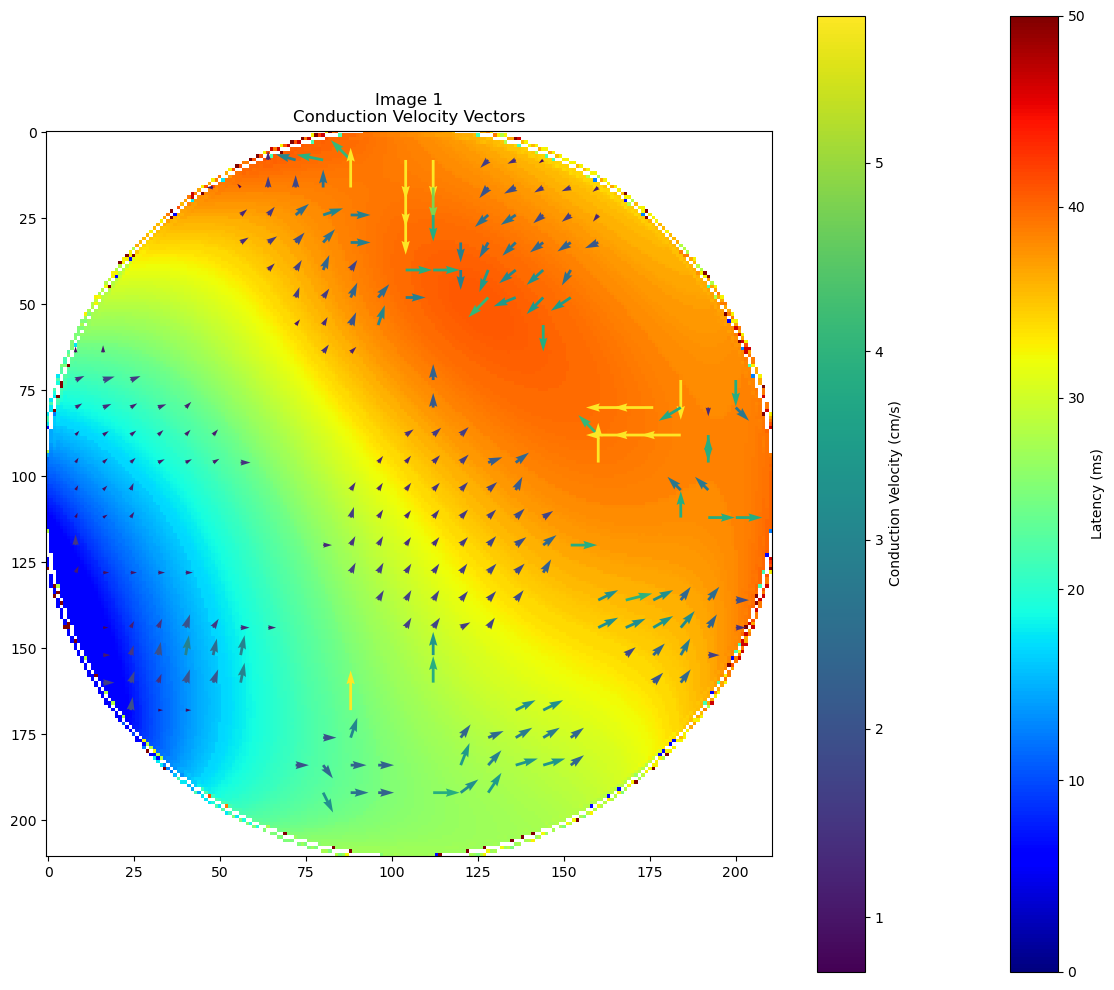

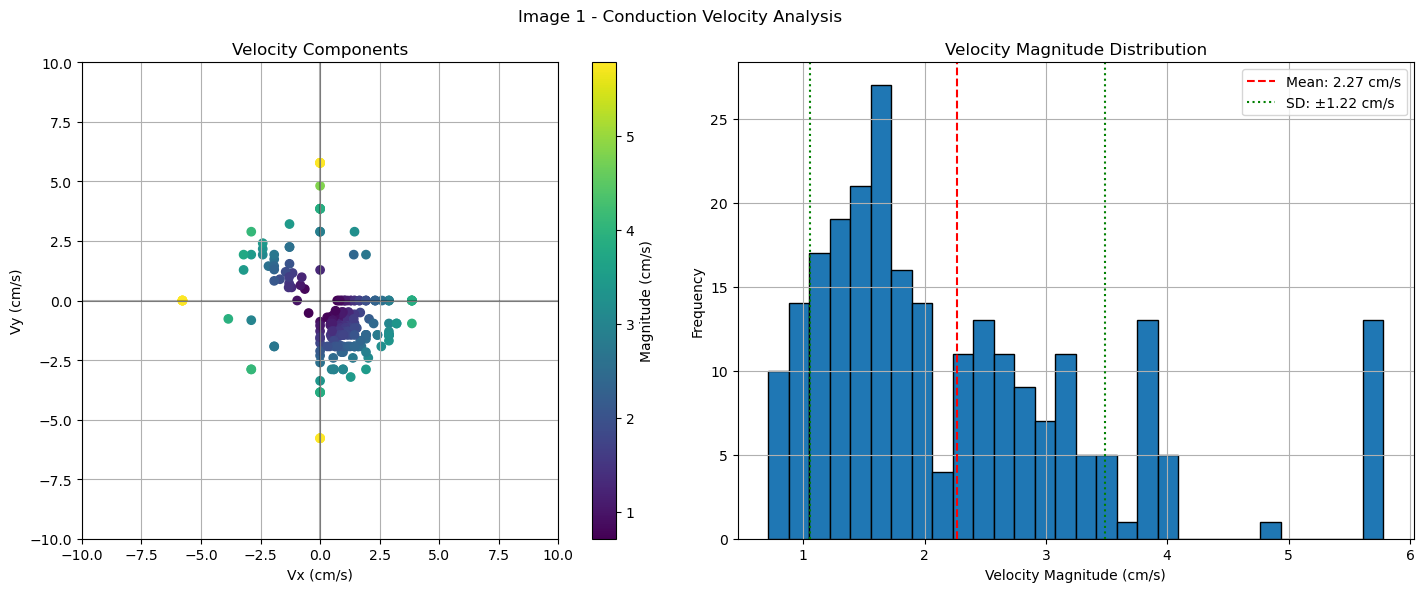


Conduction Velocity Statistics for Image 1
Mean Velocity: 2.27 ± 1.22 cm/s
Median Velocity: 1.88 cm/s
Range: 0.71 - 5.78 cm/s
Number of vectors: 247
[(0.4446153846153838, 0.963333333333331), (1.4079487179487207, 0.0), (2.119333333333337, 0.0), (2.3120000000000003, 0.0), (2.3120000000000003, 0.0), (2.3120000000000003, 0.0), (0.0, 5.780000000000022), (1.926666666666668, 0.0), (1.7890476190476186, 0.0), (1.1009523809523794, 0.6422222222222207), (1.6514285714285712, 0.0), (1.9817142857142866, 0.0), (2.3120000000000003, 0.0), (1.9266666666666736, 0.0), (0.9633333333333368, 1.926666666666662), (3.853333333333324, 0.0), (4.816666666666673, 0.0), (2.890000000000011, 2.890000000000011), (-5.780000000000022, 0.0), (-2.890000000000011, 2.890000000000011), (0.8257142857142866, -0.642222222222222), (1.6514285714285712, 0.0), (1.100952380952381, -1.9266666666666394), (1.1926984126984117, -1.9266666666666739), (0.963333333333331, -1.926666666666662), (1.2844444444444467, 0.0), (0.6422222222222234, 1

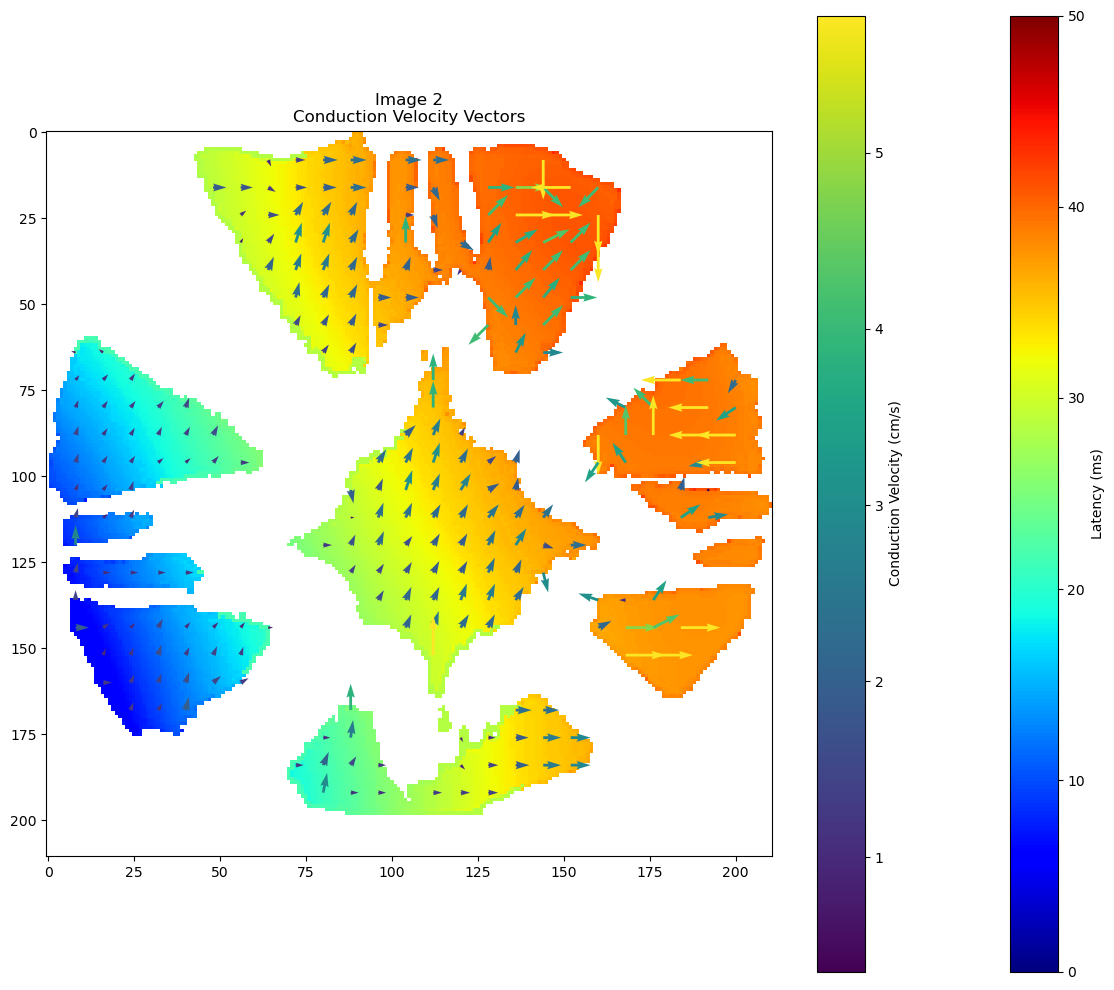

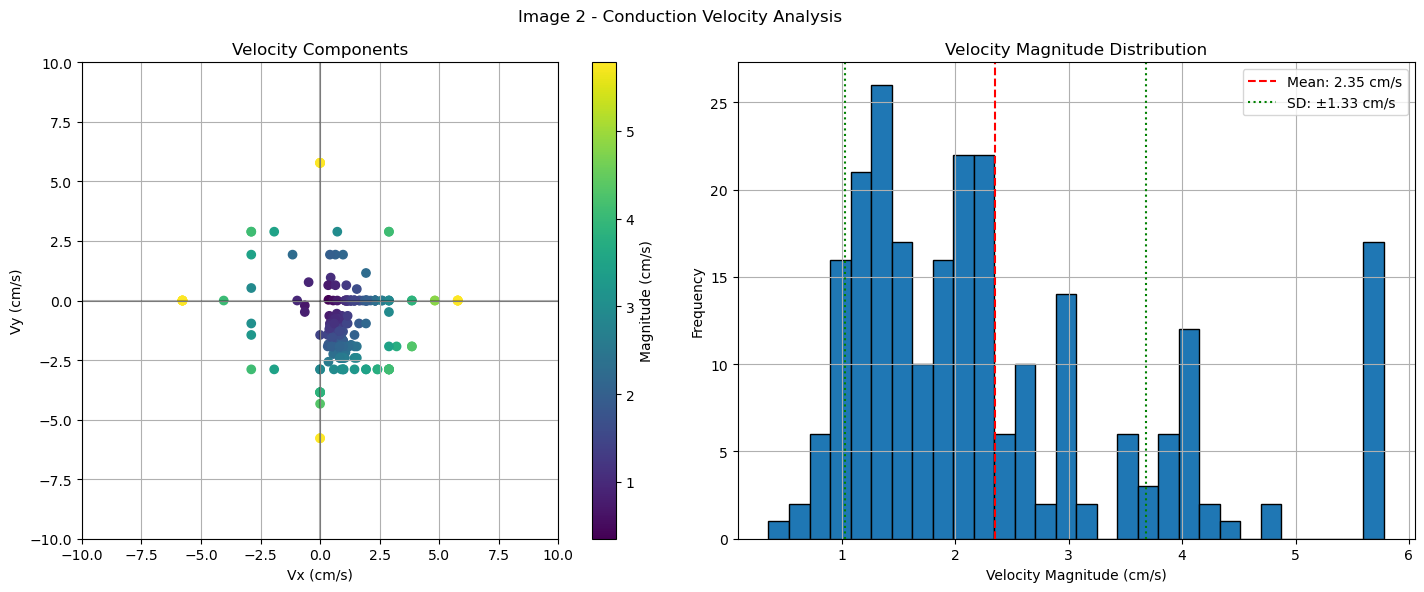


Conduction Velocity Statistics for Image 2
Mean Velocity: 2.35 ± 1.33 cm/s
Median Velocity: 2.04 cm/s
Range: 0.35 - 5.78 cm/s
Number of vectors: 242
[(-0.5254545454545448, -0.2223076923076922), (-0.7784511784511787, -0.19266666666666668), (-1.3914814814814858, -0.2568888888888889), (-1.4450000000000054, -0.41285714285714226), (-2.890000000000011, -0.5780000000000011), (-2.890000000000011, -0.722500000000001), (0.0, -1.926666666666662), (-2.890000000000011, -0.9633333333333368), (-2.890000000000011, -1.4450000000000054), (-0.8257142857142825, -0.30421052631578915), (-0.9908571428571413, -0.2917788461538462), (-1.3005000000000027, -0.3509285714285717), (-1.6858333333333337, -0.43349999999999983), (-1.2844444444444414, -0.7033862433862428), (0.0, -1.5413333333333321), (0.0, -1.8784999999999972), (0.0, -2.889999999999993), (0.0, -3.853333333333322), (1.9266666666666852, -1.4450000000000054), (1.9266666666666852, -1.9266666666666852), (-0.9633333333333326, -0.4992172739541157), (-1.6858333

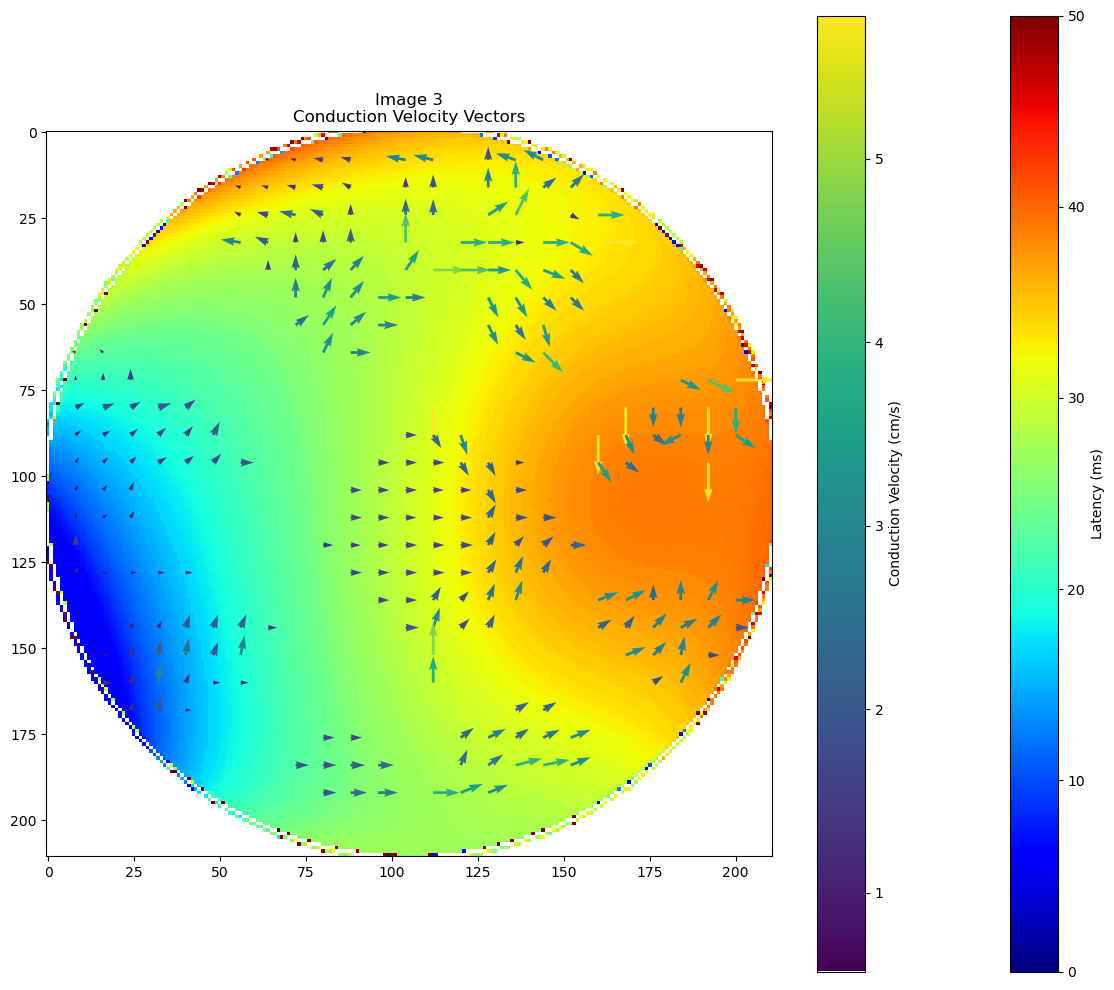

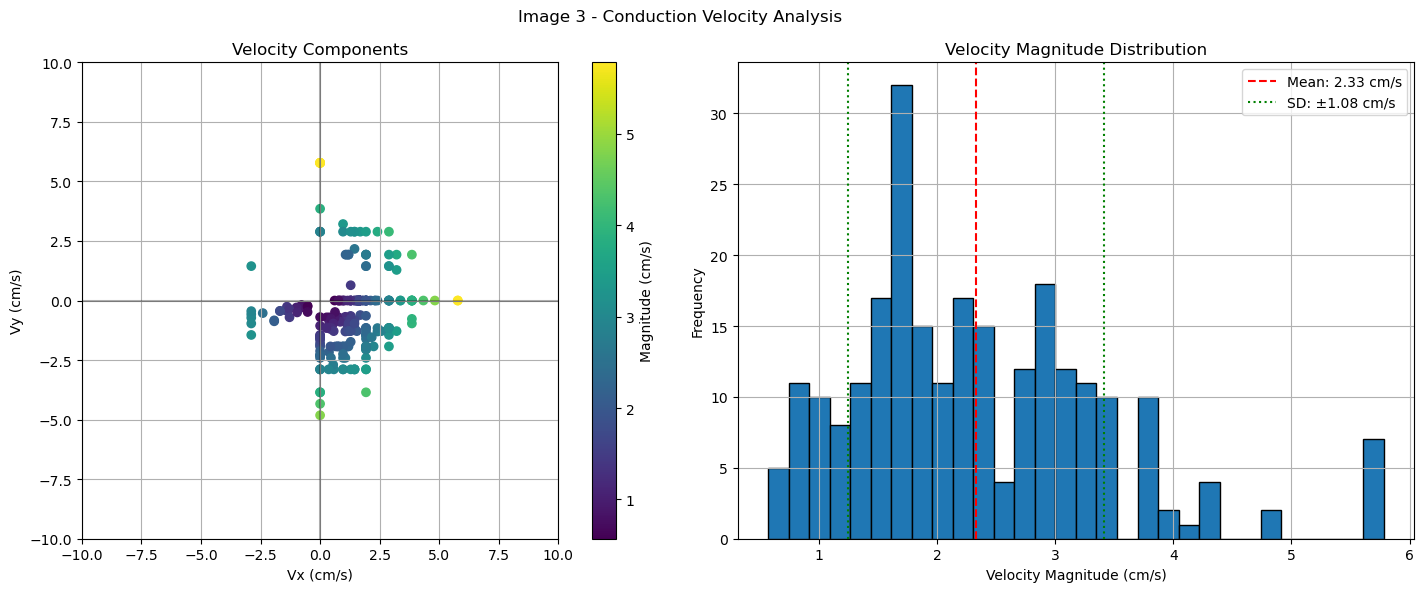


Conduction Velocity Statistics for Image 3
Mean Velocity: 2.33 ± 1.08 cm/s
Median Velocity: 2.16 cm/s
Range: 0.57 - 5.78 cm/s
Number of vectors: 245
[(-0.963333333333331, -0.3302857142857143), (-1.3428282828282805, -0.28543209876543185), (-1.9850505050505012, -0.38533333333333336), (-1.926666666666662, -0.7225000000000027), (-3.8533333333333704, -1.4450000000000054), (-3.8533333333333704, -1.926666666666662), (-5.780000000000022, 0.0), (-3.9409090909091002, 0.0), (-1.0509090909090897, 1.4449999999999925), (-0.6248648648648645, 0.0), (-1.171621621621625, -0.2568888888888889), (-2.167499999999982, -0.42787012987012957), (-2.889999999999985, -0.5030740740740739), (-1.9266666666666739, -0.8669999999999997), (0.0, -1.8784999999999945), (0.0, -4.335000000000016), (0.0, -3.853333333333324), (-2.890000000000062, 2.8899999999999593), (-1.9266666666667078, 2.5046666666666835), (-1.926666666666662, 2.890000000000011), (-1.926666666666662, 1.4450000000000054), (0.0, -0.9358095238095234), (0.0, -1

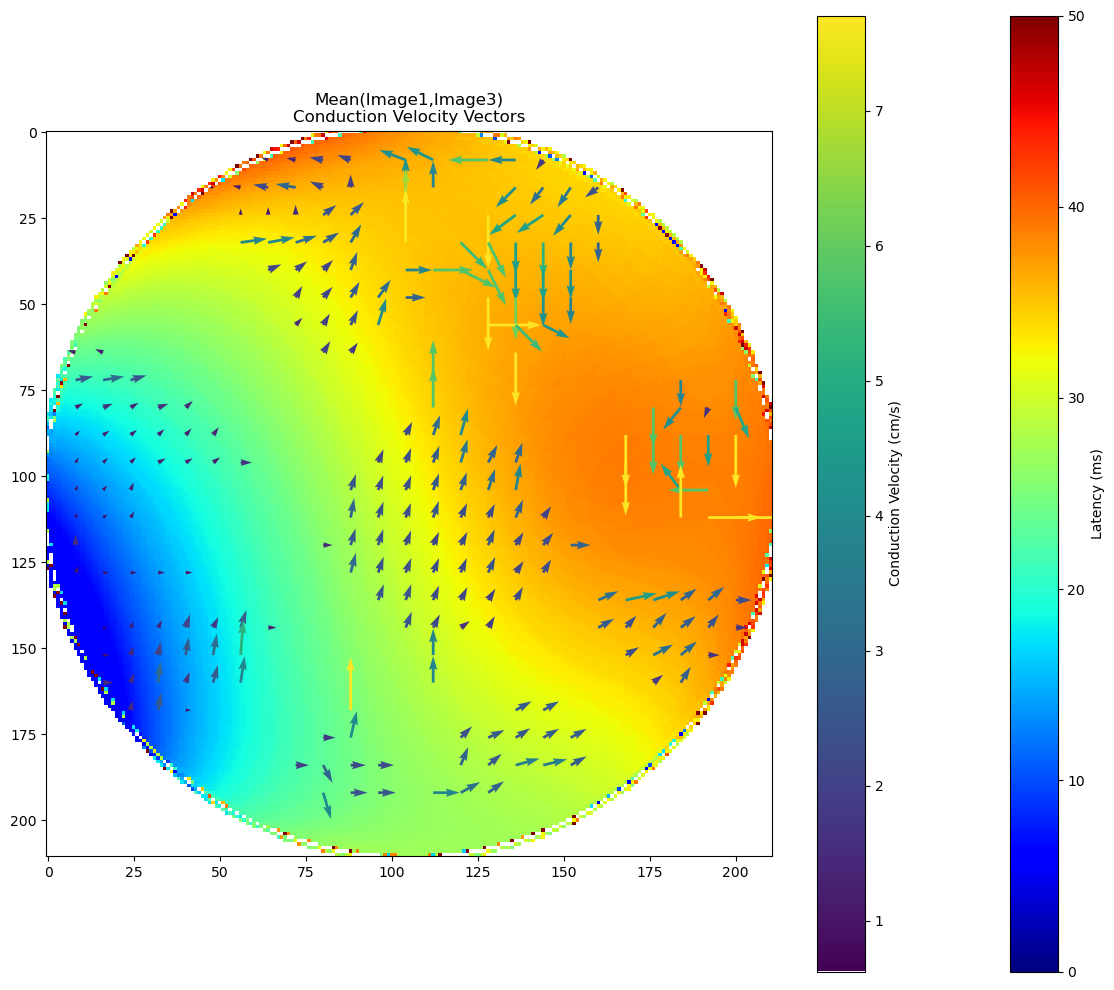

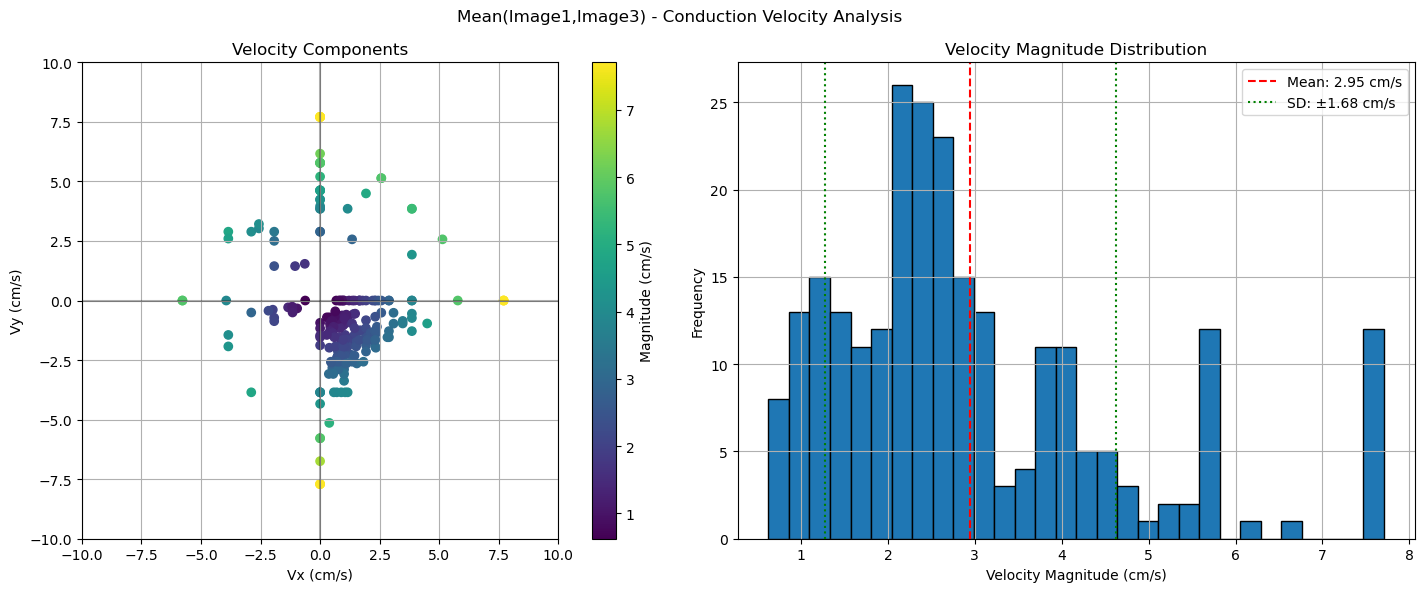


Conduction Velocity Statistics for Mean(Image1,Image3)
Mean Velocity: 2.95 ± 1.68 cm/s
Median Velocity: 2.52 cm/s
Range: 0.62 - 7.71 cm/s
Number of vectors: 247


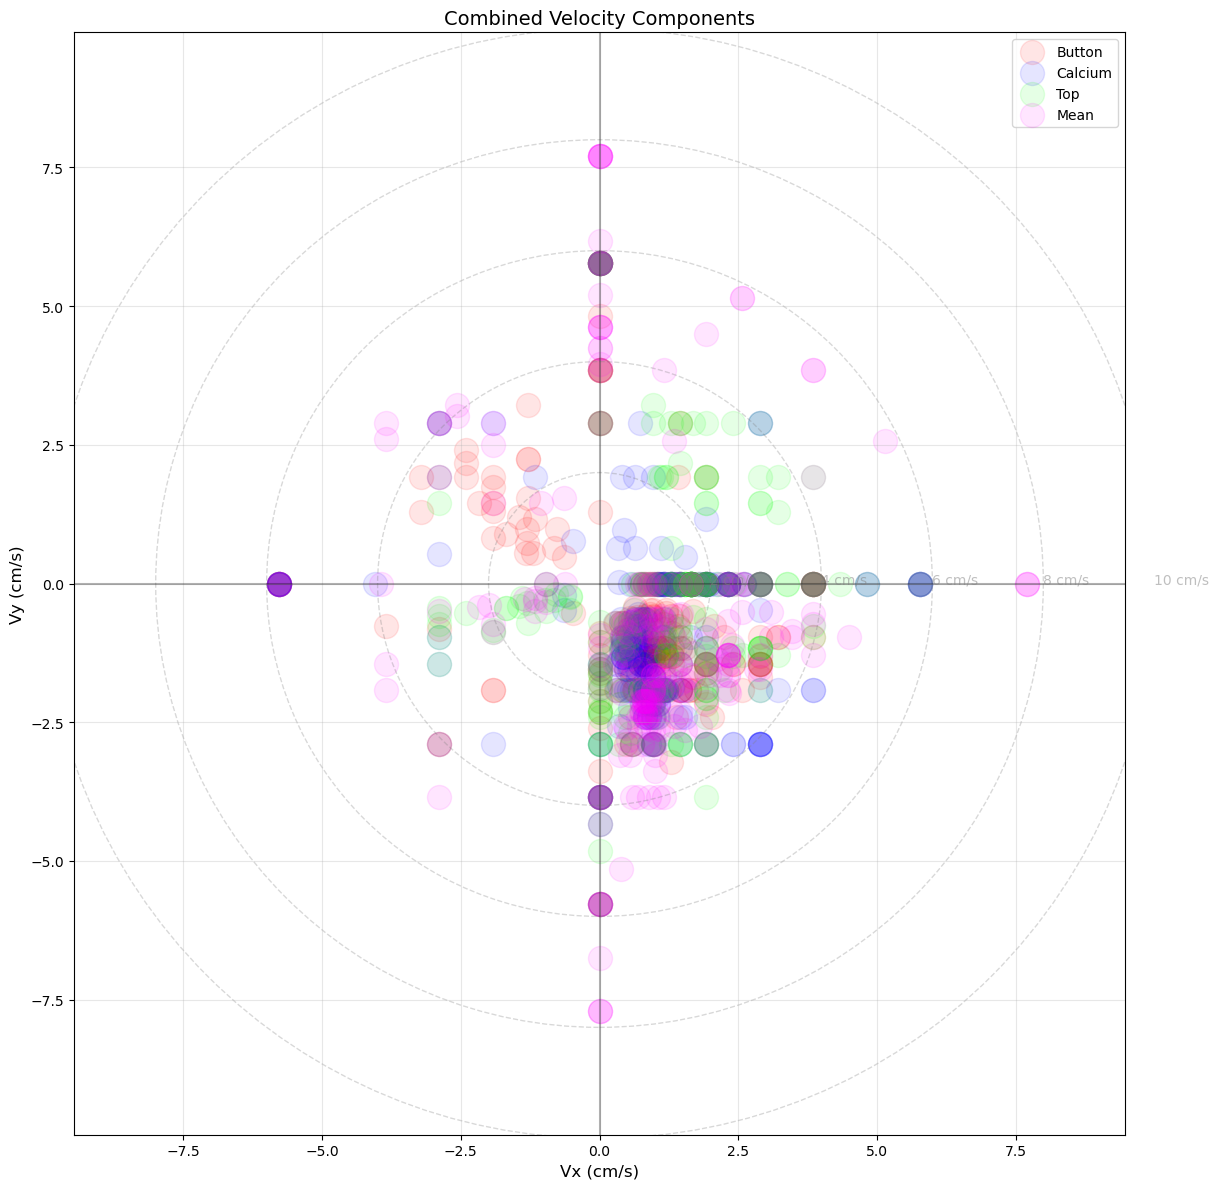

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

def calculate_velocities(data, sampling_points, sampling_rate=SAMPLING_RATE, pixel_size=2.89, max_velocity=10):
    pixel_size = pixel_size/10 #So that the unit is cm/s
    velocities = []
    positions = []
    
    points = np.array(sampling_points)
    
    for idx, (i, j) in enumerate(points):
        if np.isnan(data[i, j]):
            continue
            
        local_velocities = []
        
        adjacent_offsets = [
            (-sampling_rate, 0),  # up
            (sampling_rate, 0),   # down
            (0, -sampling_rate),  # left
            (0, sampling_rate)    # right
        ]
        
        for di, dj in adjacent_offsets:
            ni, nj = i + di, j + dj
            
            if (0 <= ni < data.shape[0] and 
                0 <= nj < data.shape[1] and 
                not np.isnan(data[ni, nj])):
                
                adjacent_idx = np.where((points == [ni, nj]).all(axis=1))[0]
                
                if len(adjacent_idx) > 0:
                    dt = data[ni, nj] - data[i, j]
                    
                    distance = sampling_rate * pixel_size / 1000
                    
                    if dt != 0:
                        velocity = distance / (dt / 1000)
                        
                        if abs(velocity) <= max_velocity:  # Filter out high velocities
                            dx = dj * pixel_size / 1000
                            dy = di * pixel_size / 1000
                            
                            dist = np.sqrt(dx**2 + dy**2)
                            vx = velocity * (dx / dist)
                            vy = velocity * (dy / dist)
                            
                            local_velocities.append((vx, vy))
        
        if local_velocities:
            mean_vx = np.mean([v[0] for v in local_velocities])
            mean_vy = np.mean([v[1] for v in local_velocities])
            magnitude = np.sqrt(mean_vx**2 + mean_vy**2)
            
            if magnitude <= max_velocity:  # Additional check for mean velocity
                velocities.append((mean_vx, mean_vy))
                positions.append((j, i))
    
    return positions, velocities

def plot_combined_velocity_scatter(all_velocities, titles):
    plt.figure(figsize=(12, 12))
    
    # Define colors for each dataset
    colors = ['blue', 'red', 'green', 'purple']
    markers = ['o', 'o', 'o', 'o']
    
    # Create scatter plot
    for velocities, color, title in zip(all_velocities, colors, titles):
        if len(velocities) > 0:
            velocities = np.array(velocities)
            plt.scatter(velocities[:, 0], velocities[:, 1], 
                       c='none', edgecolors=color, alpha=0.6,
                       label=title, s=100)
    
    plt.xlabel('Vx (cm/s)')
    plt.ylabel('Vy (cm/s)')
    plt.title('Combined Velocity Components')
    plt.grid(True)
    plt.axhline(y=0, color='k', linestyle='-', alpha=0.3)
    plt.axvline(x=0, color='k', linestyle='-', alpha=0.3)
    
    # Add velocity magnitude circles
    circles = [2, 4, 6, 8, 10]
    for r in circles:
        circle = plt.Circle((0, 0), r, fill=False, linestyle='--', color='gray', alpha=0.3)
        plt.gca().add_artist(circle)
        plt.text(r, 0, f'{r} cm/s', color='gray', alpha=0.5)
    
    plt.axis('equal')
    plt.legend()
    
    # Set axis limits to show full range of data
    max_vel = 10
    plt.xlim(-max_vel, max_vel)
    plt.ylim(-max_vel, max_vel)
    
    plt.tight_layout()
    plt.show()

def plot_velocity_vectors(data, positions, velocities, title):
    plt.figure(figsize=(12, 10))
    
    cmap = plt.cm.jet.copy()
    cmap.set_bad('white')
    plt.imshow(data, cmap=cmap, vmin=0, vmax=50)
    plt.colorbar(label='Latency (ms)')
    
    if len(positions) > 0:
        positions = np.array(positions)
        velocities = np.array(velocities)
        
        scale = .5
        magnitudes = np.sqrt(velocities[:, 0]**2 + velocities[:, 1]**2)
        
        plt.quiver(positions[:, 0], positions[:, 1], 
                  velocities[:, 0], velocities[:, 1],
                  magnitudes,
                  angles='xy', scale_units='xy', scale=scale,
                  cmap='viridis')
        
        plt.colorbar(label='Conduction Velocity (cm/s)')
    
    plt.title(f'{title}\nConduction Velocity Vectors')
    plt.axis('on')
    plt.tight_layout()
    plt.show()

def plot_velocity_scatter(velocities, title):
    if len(velocities) == 0:
        print(f"No valid velocities to plot for {title}")
        return
        
    velocities = np.array(velocities)
    vx = velocities[:, 0]
    vy = velocities[:, 1]
    magnitudes = np.sqrt(vx**2 + vy**2)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    scatter = ax1.scatter(vx, vy, c=magnitudes, cmap='viridis')
    ax1.set_xlabel('Vx (cm/s)')
    ax1.set_ylabel('Vy (cm/s)')
    ax1.set_title('Velocity Components')
    ax1.grid(True)
    ax1.axhline(y=0, color='k', linestyle='-', alpha=0.3)
    ax1.axvline(x=0, color='k', linestyle='-', alpha=0.3)
    fig.colorbar(scatter, ax=ax1, label='Magnitude (cm/s)')
    
    ax1.set_aspect('equal')
    ax1.set_xlim(-10, 10)
    ax1.set_ylim(-10, 10)
    
    ax2.hist(magnitudes, bins=30, edgecolor='black')
    ax2.set_xlabel('Velocity Magnitude (cm/s)')
    ax2.set_ylabel('Frequency')
    ax2.set_title('Velocity Magnitude Distribution')
    
    mean_vel = np.mean(magnitudes)
    std_vel = np.std(magnitudes)
    ax2.axvline(mean_vel, color='r', linestyle='--', label=f'Mean: {mean_vel:.2f} cm/s')
    ax2.axvline(mean_vel + std_vel, color='g', linestyle=':', label=f'SD: ±{std_vel:.2f} cm/s')
    ax2.axvline(mean_vel - std_vel, color='g', linestyle=':')
    ax2.grid(True)
    ax2.legend()
    
    plt.suptitle(f'{title} - Conduction Velocity Analysis')
    plt.tight_layout()
    plt.show()
    
    print(f"\nConduction Velocity Statistics for {title}")
    print(f"Mean Velocity: {mean_vel:.2f} ± {std_vel:.2f} cm/s")
    print(f"Median Velocity: {np.median(magnitudes):.2f} cm/s")
    print(f"Range: {np.min(magnitudes):.2f} - {np.max(magnitudes):.2f} cm/s")
    print(f"Number of vectors: {len(magnitudes)}")

def main():
    data1 = np.load('data/extracted_data1.npy') / 2
    data2 = np.load('data/extracted_data2.npy') / 2
    data3 = np.load('data/extracted_data3.npy') / 2
    data_mean13 = np.nanmean(np.stack([data1, data3]), axis=0)
    
    _, _, sampling_points = sample_and_pair_data(data1, data2, sampling_rate=SAMPLING_RATE)
    
    datasets = [
        (data1, "Image 1"),
        (data2, "Image 2"),
        (data3, "Image 3"),
        (data_mean13, "Mean(Image1,Image3)")
    ]
    
    all_velocities = []
    titles = []
    
    for data, title in datasets:
        positions, velocities = calculate_velocities(data, sampling_points)
        print(velocities)
        if len(positions) > 0:
            plot_velocity_vectors(data, positions, velocities, title)
            plot_velocity_scatter(velocities, title)
            all_velocities.append(velocities)
            titles.append(title)
        else:
            print(f"No valid velocities calculated for {title}")
    
    # Create combined scatter plot
    if len(all_velocities) > 0:
        titles = ["Button", "Calcium", "Top", "Mean"]
        plot_combined_velocity_scatter(all_velocities, titles)

def plot_combined_velocity_scatter(all_velocities, titles):
    plt.figure(figsize=(12, 12))
    
    # Define colors for each dataset - using more distinct colors
    colors = ['#FF0000', '#0000FF', '#00FF00', '#FF00FF']  # Red, Blue, Green, Magenta
    
    # Create scatter plot with larger, more transparent circles
    for velocities, color, title in zip(all_velocities, colors, titles):
        if len(velocities) > 0:
            velocities = np.array(velocities)
            plt.scatter(velocities[:, 0], velocities[:, 1], 
                       c=color, alpha=0.1,  # More transparent, solid color
                       label=title, s=300)   # Larger circles
    
    plt.xlabel('Vx (cm/s)', fontsize=12)
    plt.ylabel('Vy (cm/s)', fontsize=12)
    plt.title('Combined Velocity Components', fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.axhline(y=0, color='k', linestyle='-', alpha=0.3)
    plt.axvline(x=0, color='k', linestyle='-', alpha=0.3)
    
    # Add velocity magnitude circles
    circles = [2, 4, 6, 8, 10]
    for r in circles:
        circle = plt.Circle((0, 0), r, fill=False, linestyle='--', color='gray', alpha=0.3)
        plt.gca().add_artist(circle)
        plt.text(r, 0, f'{r} cm/s', color='gray', alpha=0.5)
    
    plt.axis('equal')
    plt.legend(fontsize=10)
    
    # Set axis limits
    max_vel = 10
    plt.xlim(-max_vel, max_vel)
    plt.ylim(-max_vel, max_vel)
    
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()

D:\temp\ipykernel_29280\2532731808.py:8: RuntimeWarning: Mean of empty slice
  data_mean13 = np.nanmean(np.stack([data1, data3]), axis=0)


(211, 211)
(211, 211)
[(0.0, -1.2844444444444467), (-2.8899999999999593, -0.8257142857142825), (-3.8533333333333135, -0.7706666666666667), (-2.890000000000011, -2.890000000000011), (0.0, 5.7799999999999185), (0.0, 5.780000000000022), (-1.1560000000000001, 1.1560000000000001), (-1.1988148148148157, 0.5504761904761911), (-0.6422222222222234, 0.481666666666667), (-0.963333333333331, 0.0), (-0.4816666666666655, -0.5254545454545465), (0.0, -1.6055555555555543), (0.0, -1.7890476190476194), (0.0, -2.6010000000000053), (0.0, -5.780000000000022), (0.0, 5.77999999999997), (0.0, 4.816666666666673), (-1.2844444444444414, 1.5413333333333334), (-1.6858333333333337, 0.8945238095238088), (-1.3005000000000027, 0.7225000000000019), (-1.3211428571428578, 0.5504761904761911), (-0.8257142857142866, 0.6422222222222234), (0.9633333333333369, -0.8319696969696974), (0.9633333333333369, -1.1926984126984117), (1.9266666666666739, -1.6055555555555527), (2.890000000000011, -0.9633333333333369), (2.890000000000011,

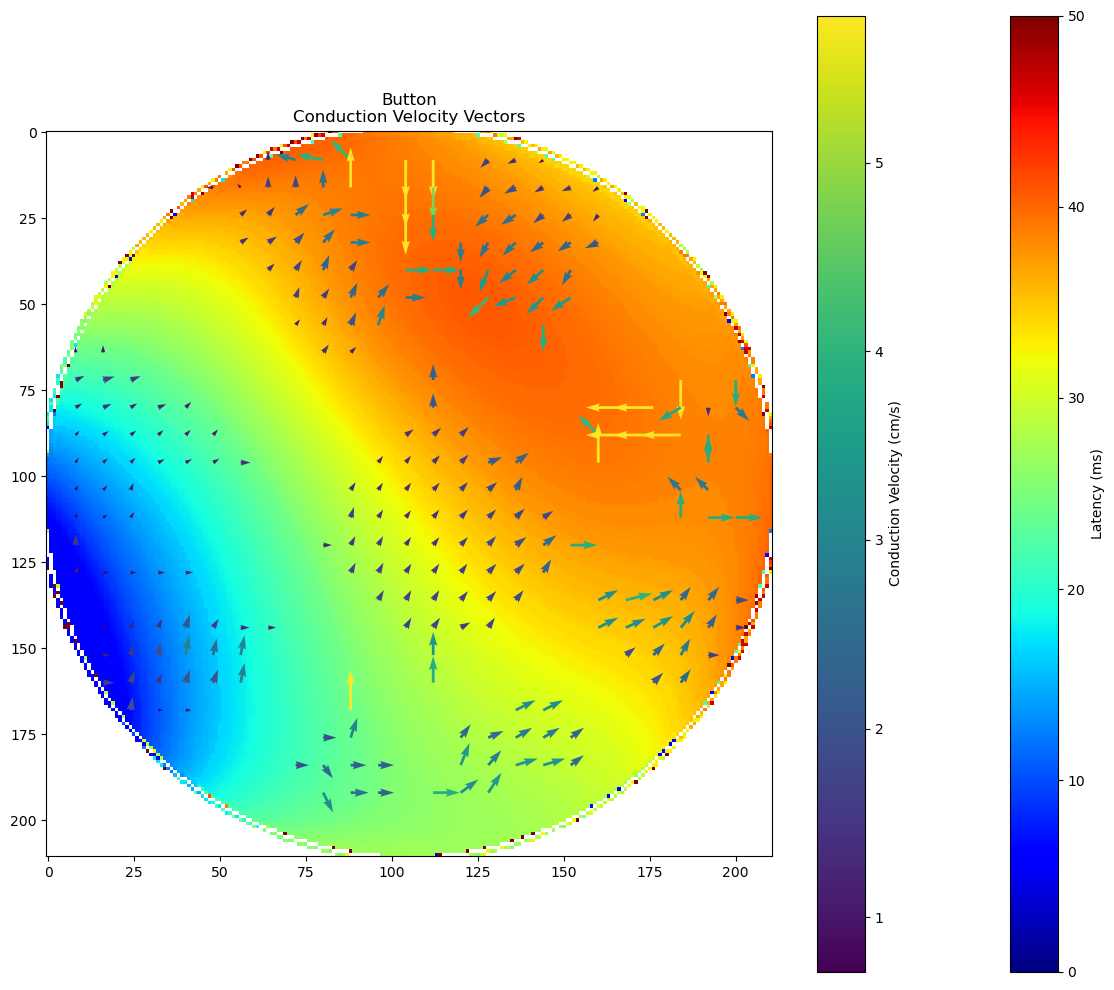

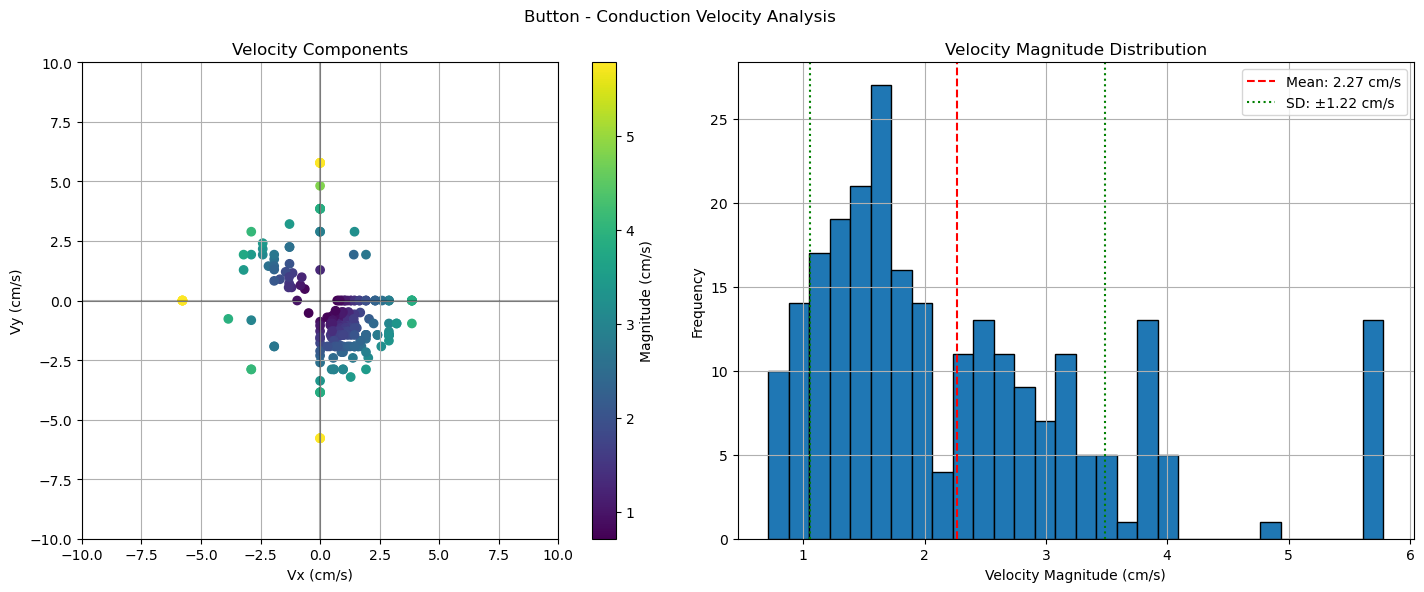


Conduction Velocity Statistics for Button
Mean Velocity: 2.27 ± 1.22 cm/s
Median Velocity: 1.88 cm/s
Range: 0.71 - 5.78 cm/s
Number of vectors: 247
[(0.4446153846153838, 0.963333333333331), (1.4079487179487207, 0.0), (2.119333333333337, 0.0), (2.3120000000000003, 0.0), (2.3120000000000003, 0.0), (2.3120000000000003, 0.0), (0.0, 5.780000000000022), (1.926666666666668, 0.0), (1.7890476190476186, 0.0), (1.1009523809523794, 0.6422222222222207), (1.6514285714285712, 0.0), (1.9817142857142866, 0.0), (2.3120000000000003, 0.0), (1.9266666666666736, 0.0), (0.9633333333333368, 1.926666666666662), (3.853333333333324, 0.0), (4.816666666666673, 0.0), (2.890000000000011, 2.890000000000011), (-5.780000000000022, 0.0), (-2.890000000000011, 2.890000000000011), (0.8257142857142866, -0.642222222222222), (1.6514285714285712, 0.0), (1.100952380952381, -1.9266666666666394), (1.1926984126984117, -1.9266666666666739), (0.963333333333331, -1.926666666666662), (1.2844444444444467, 0.0), (0.6422222222222234, 1.

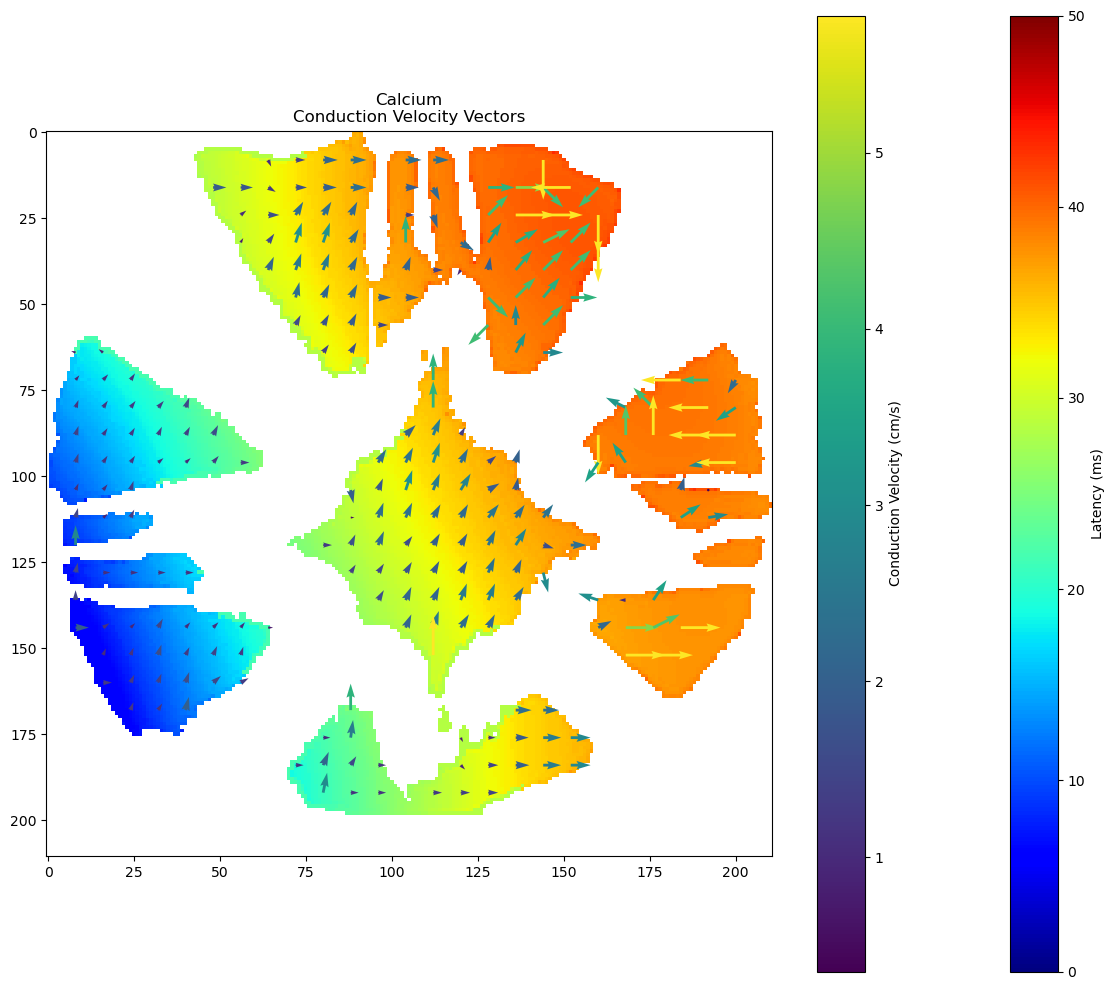

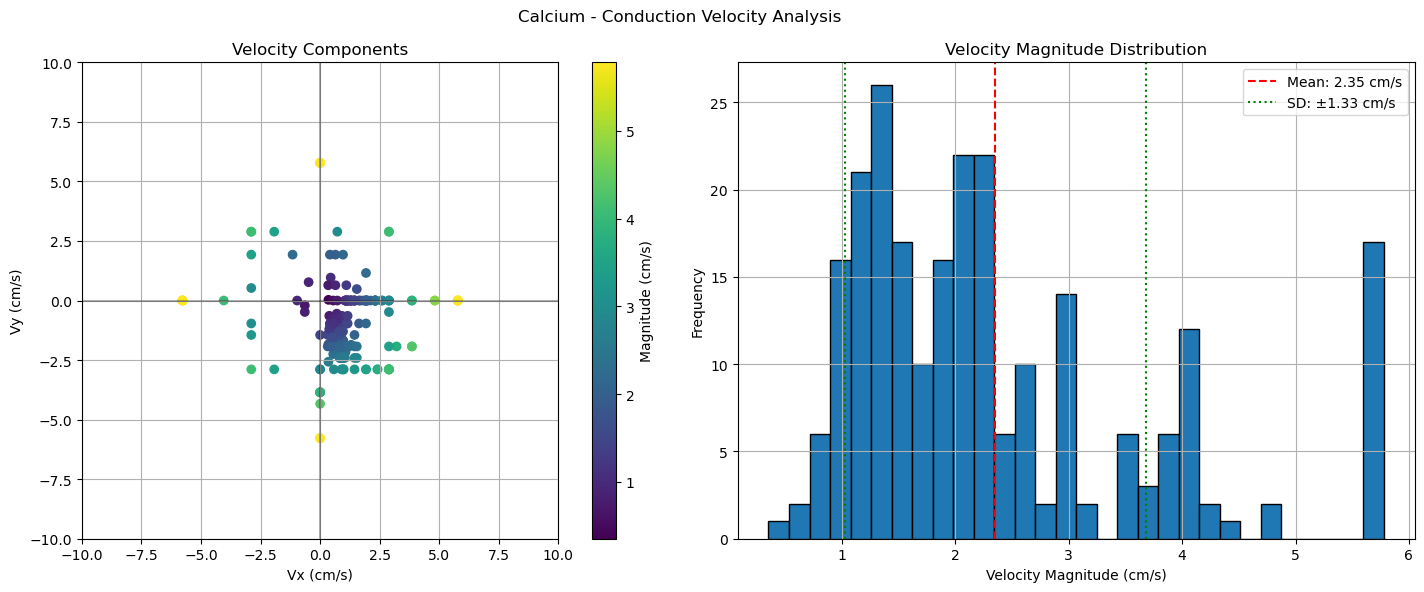


Conduction Velocity Statistics for Calcium
Mean Velocity: 2.35 ± 1.33 cm/s
Median Velocity: 2.04 cm/s
Range: 0.35 - 5.78 cm/s
Number of vectors: 242
[(-0.5254545454545448, -0.2223076923076922), (-0.7784511784511787, -0.19266666666666668), (-1.3914814814814858, -0.2568888888888889), (-1.4450000000000054, -0.41285714285714226), (-2.890000000000011, -0.5780000000000011), (-2.890000000000011, -0.722500000000001), (0.0, -1.926666666666662), (-2.890000000000011, -0.9633333333333368), (-2.890000000000011, -1.4450000000000054), (-0.8257142857142825, -0.30421052631578915), (-0.9908571428571413, -0.2917788461538462), (-1.3005000000000027, -0.3509285714285717), (-1.6858333333333337, -0.43349999999999983), (-1.2844444444444414, -0.7033862433862428), (0.0, -1.5413333333333321), (0.0, -1.8784999999999972), (0.0, -2.889999999999993), (0.0, -3.853333333333322), (1.9266666666666852, -1.4450000000000054), (1.9266666666666852, -1.9266666666666852), (-0.9633333333333326, -0.4992172739541157), (-1.6858333

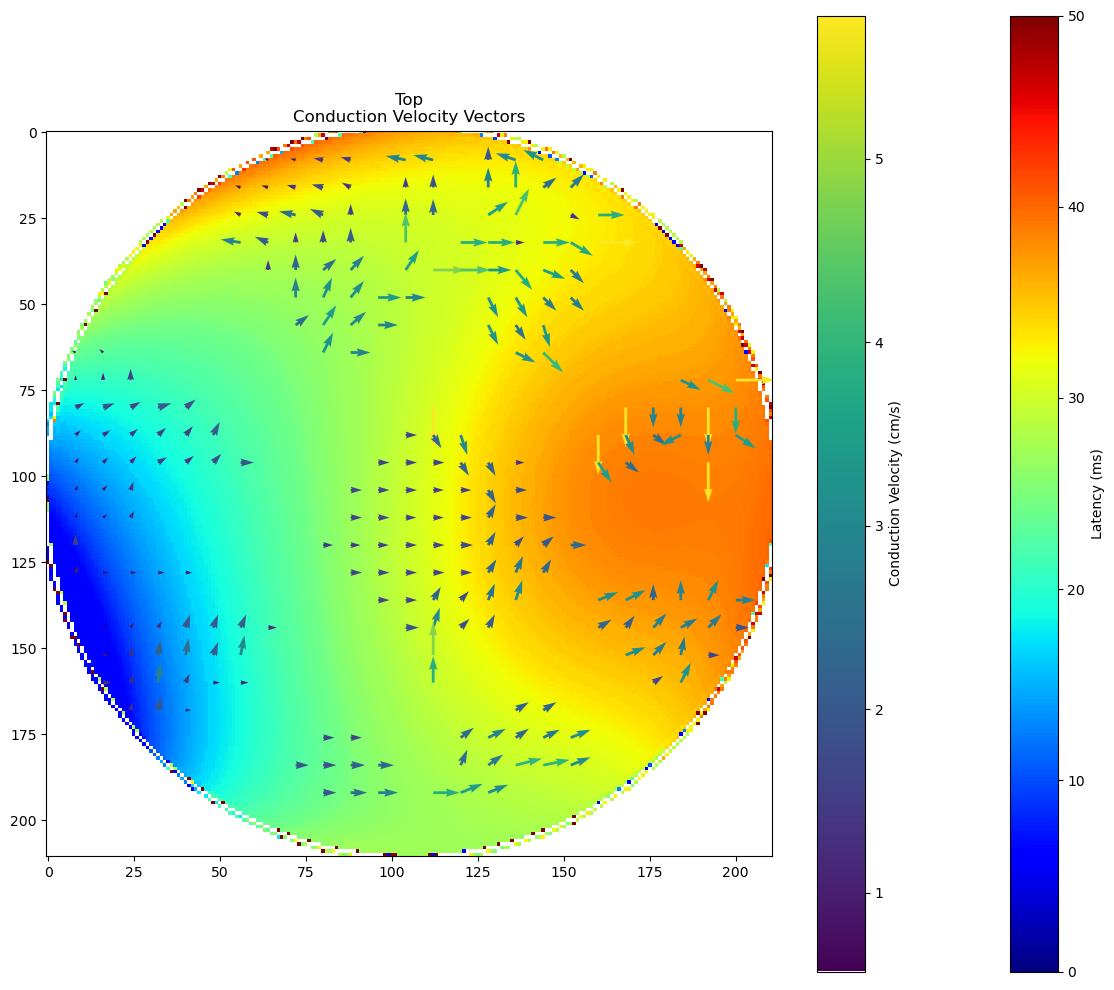

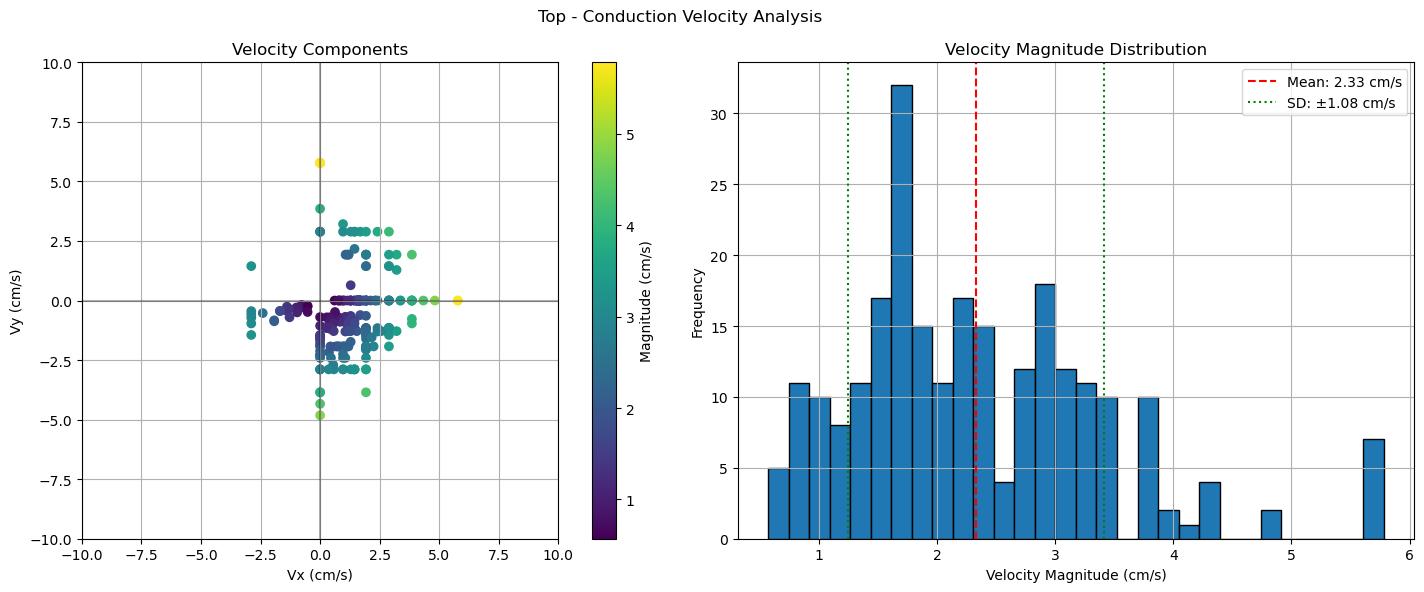


Conduction Velocity Statistics for Top
Mean Velocity: 2.33 ± 1.08 cm/s
Median Velocity: 2.16 cm/s
Range: 0.57 - 5.78 cm/s
Number of vectors: 245
[(-0.963333333333331, -0.3302857142857143), (-1.3428282828282805, -0.28543209876543185), (-1.9850505050505012, -0.38533333333333336), (-1.926666666666662, -0.7225000000000027), (-3.8533333333333704, -1.4450000000000054), (-3.8533333333333704, -1.926666666666662), (-5.780000000000022, 0.0), (-3.9409090909091002, 0.0), (-1.0509090909090897, 1.4449999999999925), (-0.6248648648648645, 0.0), (-1.171621621621625, -0.2568888888888889), (-2.167499999999982, -0.42787012987012957), (-2.889999999999985, -0.5030740740740739), (-1.9266666666666739, -0.8669999999999997), (0.0, -1.8784999999999945), (0.0, -4.335000000000016), (0.0, -3.853333333333324), (-2.890000000000062, 2.8899999999999593), (-1.9266666666667078, 2.5046666666666835), (-1.926666666666662, 2.890000000000011), (-1.926666666666662, 1.4450000000000054), (0.0, -0.9358095238095234), (0.0, -1.167

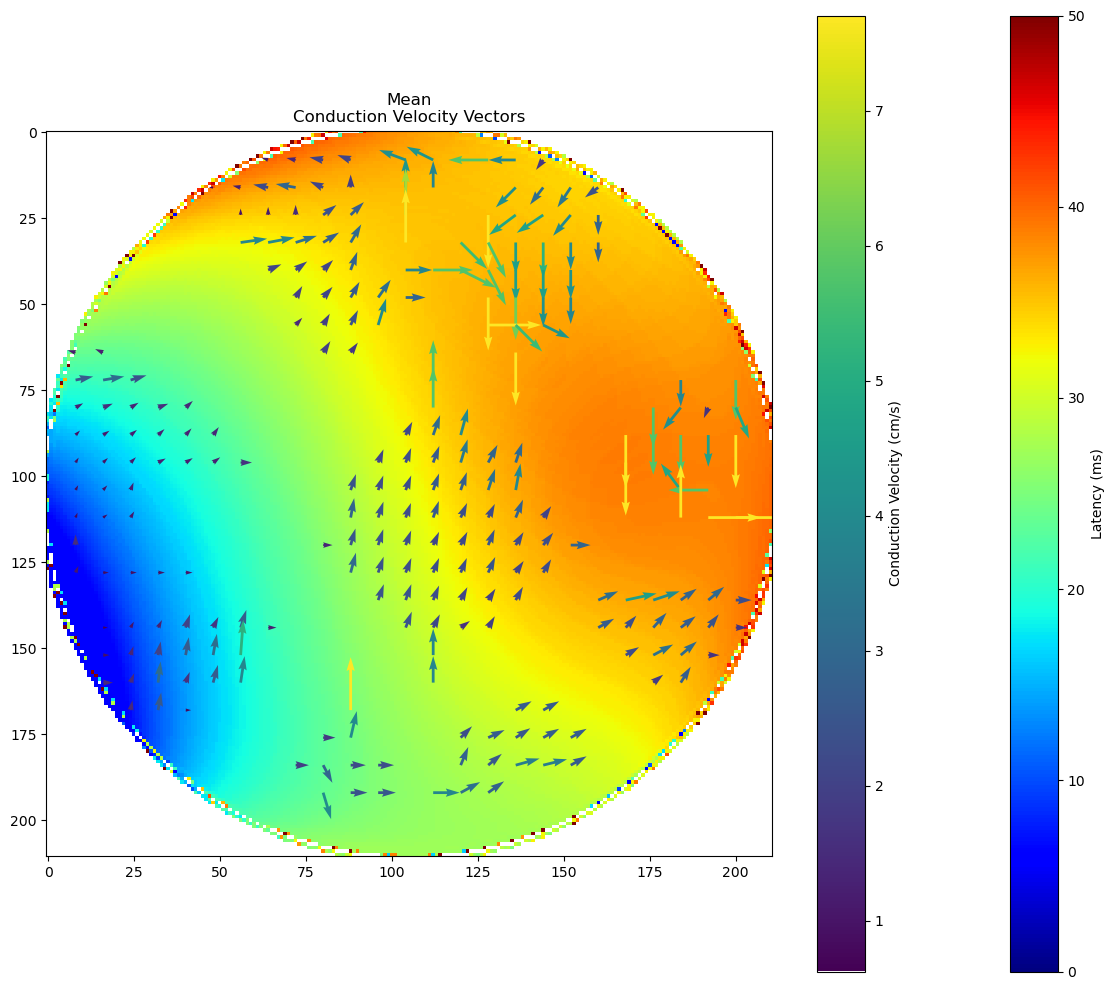

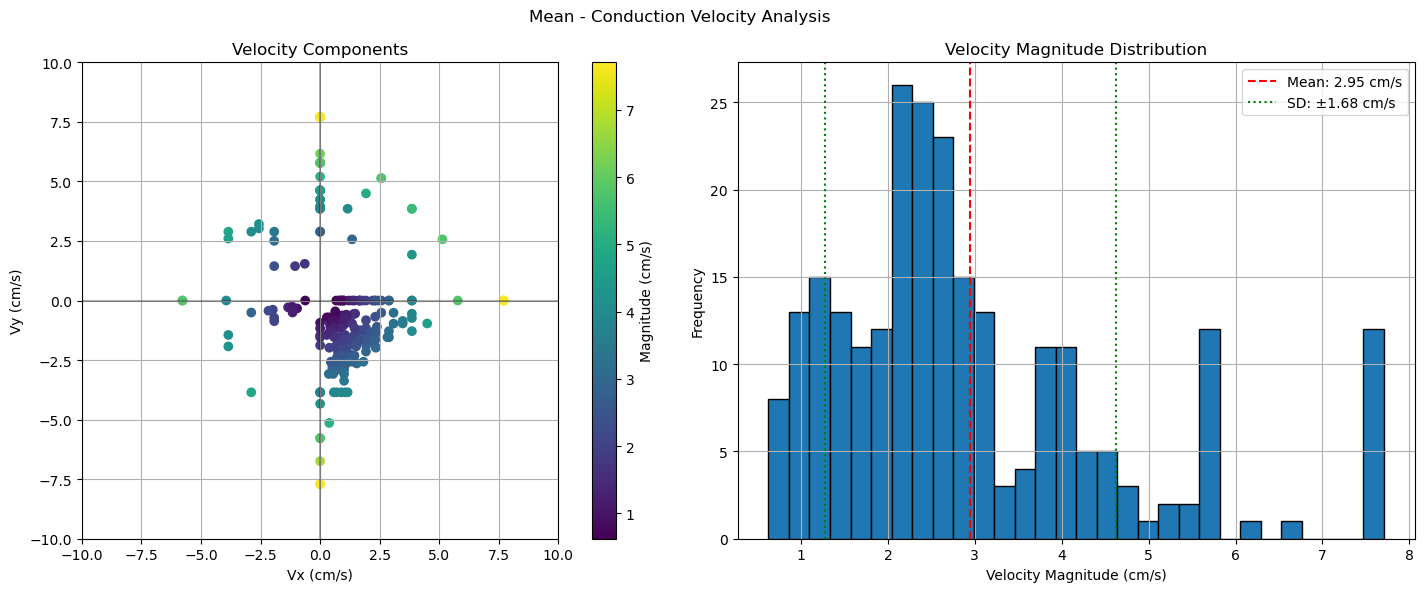


Conduction Velocity Statistics for Mean
Mean Velocity: 2.95 ± 1.68 cm/s
Median Velocity: 2.52 cm/s
Range: 0.62 - 7.71 cm/s
Number of vectors: 247
Excel file 'velocity_amplitude_results.xlsx' created successfully.


In [18]:
import numpy as np
import pandas as pd

def main():
    data1 = np.load('data/extracted_data1.npy') / 2
    data2 = np.load('data/extracted_data2.npy') / 2
    data3 = np.load('data/extracted_data3.npy') / 2
    data_mean13 = np.nanmean(np.stack([data1, data3]), axis=0)
    
    _, _, sampling_points = sample_and_pair_data(data1, data2, sampling_rate=SAMPLING_RATE)
    
    datasets = [
        (data1, "Button"),
        (data2, "Calcium"),
        (data3, "Top"),
        (data_mean13, "Mean")
    ]
    
    all_velocities = []
    titles = []
    
    for data, title in datasets:
        positions, velocities = calculate_velocities(data, sampling_points)
        print(velocities)
        print(velocities)
        if len(positions) > 0:
            plot_velocity_vectors(data, positions, velocities, title)
            plot_velocity_scatter(velocities, title)
            all_velocities.append(velocities)
            titles.append(title)
        else:
            print(f"No valid velocities calculated for {title}")

    # Calculate amplitude and save results
    if all_velocities:
        amplitude_data = {}

        for velocities, title in zip(all_velocities, titles):
            velocities = np.array(velocities)
            amp = np.sqrt(velocities[:, 0]**2 + velocities[:, 1]**2)   # Compute amplitude
            
            # Create heading with mean, median, and std
            heading = f'{title} (Mean: {np.mean(amp):.2f}, Median: {np.median(amp):.2f}, Std: {np.std(amp):.2f})'
            amplitude_data[heading] = amp

        df = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in amplitude_data.items()]))
        df.to_excel('velocity_amplitude_results.xlsx', index=False)
        print("Excel file 'velocity_amplitude_results.xlsx' created successfully.")

main()


(211, 211)
(211, 211)


D:\temp\ipykernel_29280\1042505057.py:97: RuntimeWarning: Mean of empty slice
  data_mean = np.nanmean(np.stack([data1, data3]), axis=0)  # Mean


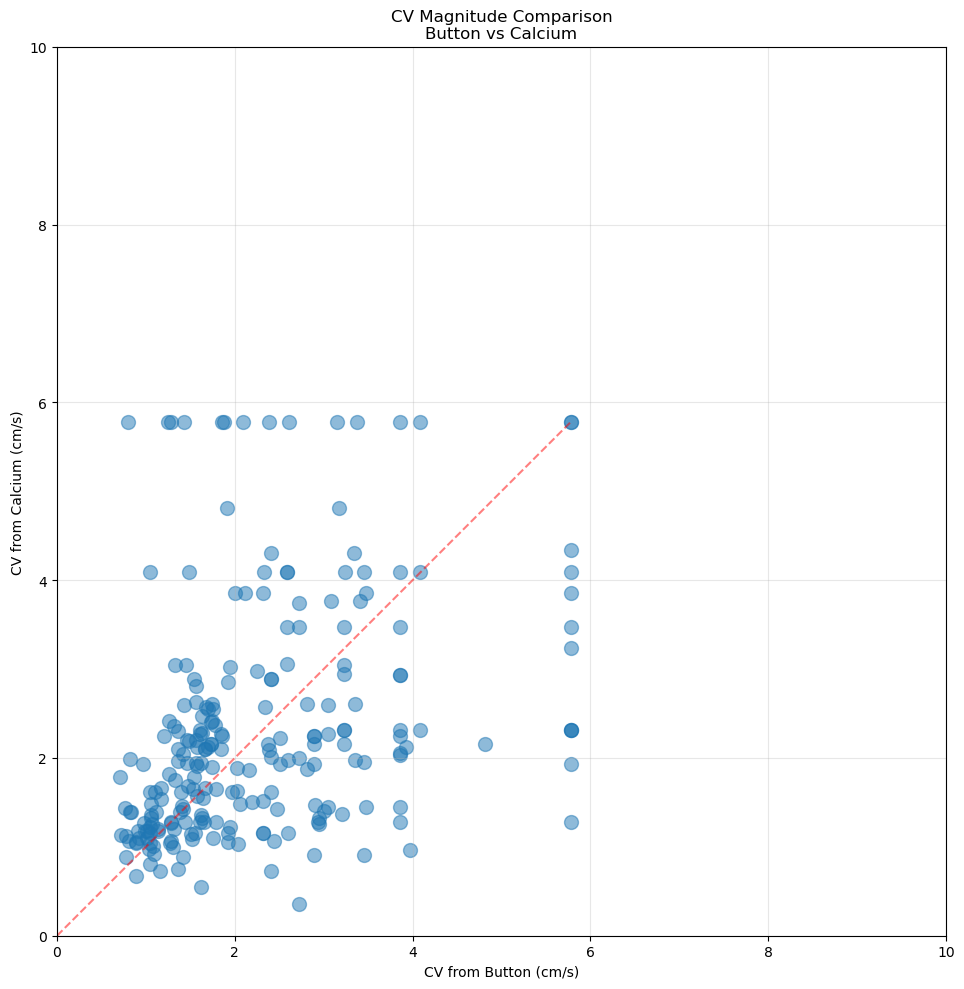


Statistical Comparison - Button vs Calcium
--------------------------------------------------
Number of matched points: 231

Correlation Analysis:
  Pearson Correlation (r) = 0.357
  P-value = 2.30e-08

Error Metrics:
  Root Mean Square Error = 1.43 cm/s
  Mean Absolute Error = 1.01 cm/s

Agreement Thresholds:
  Within ±0.5 cm/s: 40.3%
  Within ±1.0 cm/s: 65.8%
  Within ±2.0 cm/s: 87.9%

Point counts for Button vs Calcium:
Original Button points: 247
Original Calcium points: 242
Matched points: 231


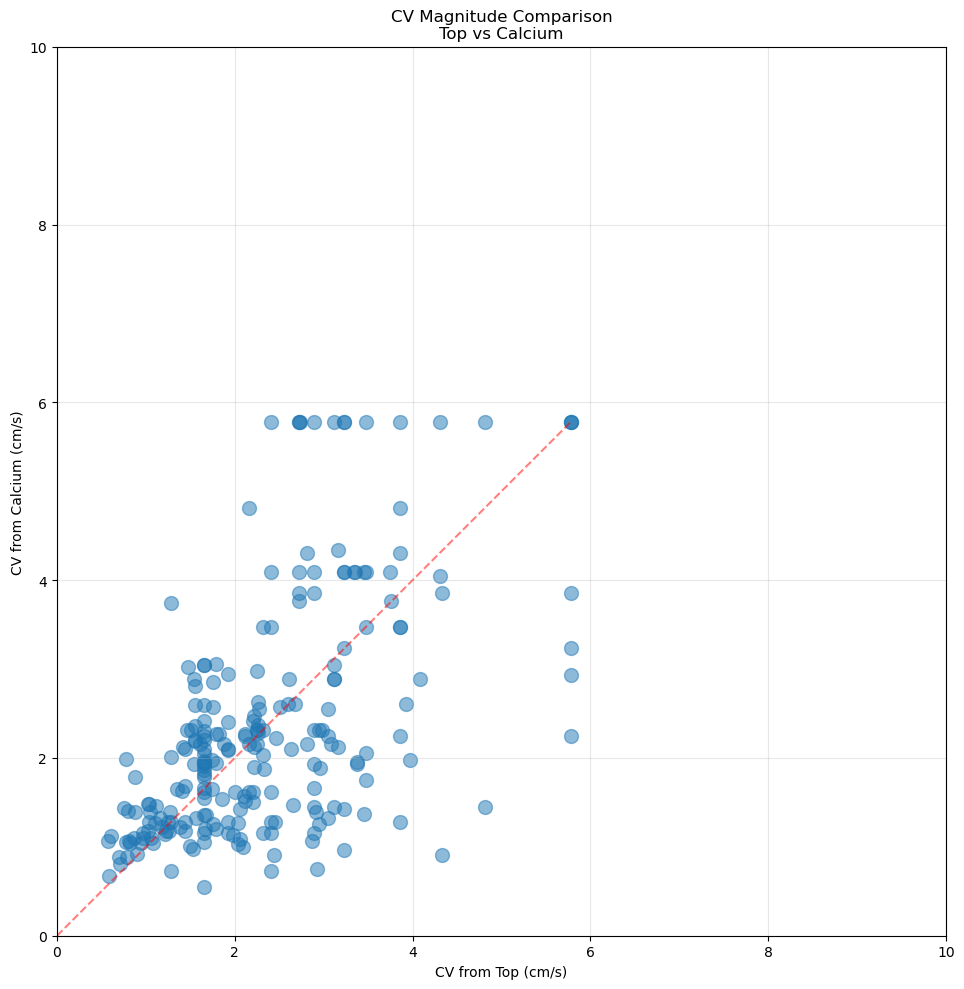


Statistical Comparison - Top vs Calcium
--------------------------------------------------
Number of matched points: 230

Correlation Analysis:
  Pearson Correlation (r) = 0.567
  P-value = 6.11e-21

Error Metrics:
  Root Mean Square Error = 1.13 cm/s
  Mean Absolute Error = 0.81 cm/s

Agreement Thresholds:
  Within ±0.5 cm/s: 45.2%
  Within ±1.0 cm/s: 69.1%
  Within ±2.0 cm/s: 91.3%

Point counts for Top vs Calcium:
Original Top points: 245
Original Calcium points: 242
Matched points: 230


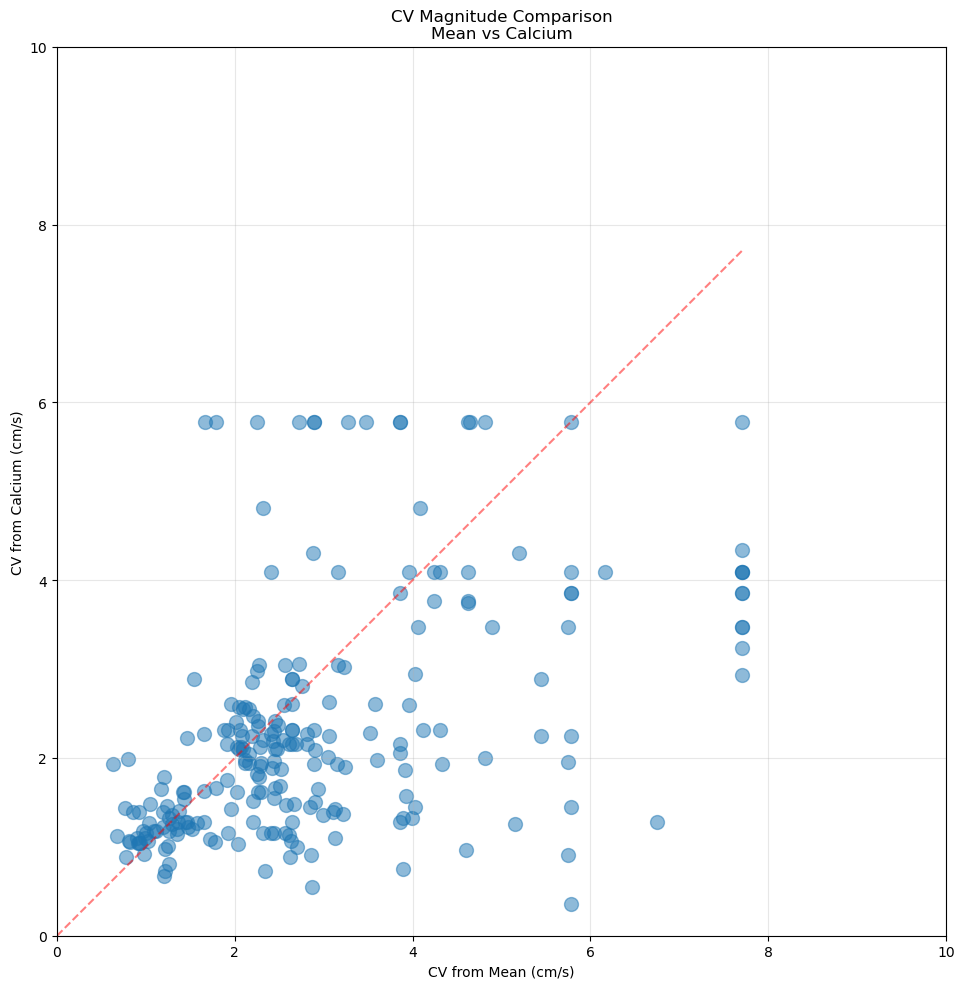


Statistical Comparison - Mean vs Calcium
--------------------------------------------------
Number of matched points: 231

Correlation Analysis:
  Pearson Correlation (r) = 0.483
  P-value = 7.14e-15

Error Metrics:
  Root Mean Square Error = 1.66 cm/s
  Mean Absolute Error = 1.13 cm/s

Agreement Thresholds:
  Within ±0.5 cm/s: 44.6%
  Within ±1.0 cm/s: 61.9%
  Within ±2.0 cm/s: 81.8%

Point counts for Mean vs Calcium:
Original Mean points: 247
Original Calcium points: 242
Matched points: 231


In [19]:
def calculate_cv_magnitudes(velocities):
    """Calculate magnitude of velocity vectors"""
    return np.sqrt(np.array([v[0]**2 + v[1]**2 for v in velocities]))

def match_valid_points(data1, data2, positions1, positions2):
    """Match points that exist in both datasets after filtering"""
    positions1 = np.array(positions1)
    positions2 = np.array(positions2)
    
    # Create dictionary of positions for quick lookup
    pos_dict1 = {(x, y): i for i, (x, y) in enumerate(positions1)}
    pos_dict2 = {(x, y): i for i, (x, y) in enumerate(positions2)}
    
    # Find common positions
    common_positions = set(map(tuple, positions1)) & set(map(tuple, positions2))
    
    # Get indices for matched positions
    indices1 = [pos_dict1[pos] for pos in common_positions]
    indices2 = [pos_dict2[pos] for pos in common_positions]
    
    return indices1, indices2

def create_cv_comparison_plot(cv1, cv2, title1, title2):
    """Create scatter plot comparing CV magnitudes between two methods"""
    plt.figure(figsize=(10, 10))
    
    # Create scatter plot
    plt.scatter(cv1, cv2, alpha=0.5, s=100)
    
    # Add diagonal line
    max_val = max(np.max(cv1), np.max(cv2))
    plt.plot([0, max_val], [0, max_val], 'r--', alpha=0.5, label='Identity Line')
    
    # Add labels and title
    plt.xlabel(f'CV from {title1} (cm/s)')
    plt.ylabel(f'CV from {title2} (cm/s)')
    plt.title(f'CV Magnitude Comparison\n{title1} vs {title2}')
    
    # Add grid and make square
    plt.grid(True, alpha=0.3)
    plt.axis('equal')
    plt.axis('square')
    
    # Set limits
    plt.xlim(0, 10)
    plt.ylim(0, 10)
    
    plt.tight_layout()
    plt.show()

def calculate_statistics(cv1, cv2, title1, title2):
    """Calculate and print statistical comparison between two CV sets"""
    # Calculate correlation
    correlation, p_value = stats.pearsonr(cv1, cv2)
    
    # Calculate errors
    mse = mean_squared_error(cv2, cv1)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(cv2, cv1)
    
    # Calculate differences within thresholds
    diff = np.abs(cv1 - cv2)
    acc_05 = np.mean(diff <= 0.5) * 100
    acc_1 = np.mean(diff <= 1.0) * 100
    acc_2 = np.mean(diff <= 2.0) * 100
    
    print(f"\nStatistical Comparison - {title1} vs {title2}")
    print("-" * 50)
    print(f"Number of matched points: {len(cv1)}")
    print(f"\nCorrelation Analysis:")
    print(f"  Pearson Correlation (r) = {correlation:.3f}")
    print(f"  P-value = {p_value:.2e}")
    print(f"\nError Metrics:")
    print(f"  Root Mean Square Error = {rmse:.2f} cm/s")
    print(f"  Mean Absolute Error = {mae:.2f} cm/s")
    print(f"\nAgreement Thresholds:")
    print(f"  Within ±0.5 cm/s: {acc_05:.1f}%")
    print(f"  Within ±1.0 cm/s: {acc_1:.1f}%")
    print(f"  Within ±2.0 cm/s: {acc_2:.1f}%")
    
    return {
        'correlation': correlation,
        'p_value': p_value,
        'rmse': rmse,
        'mae': mae,
        'acc_05': acc_05,
        'acc_1': acc_1,
        'acc_2': acc_2,
        'n_points': len(cv1)
    }

def main():
    # Load data and calculate velocities for all methods
    data1 = np.load('data/extracted_data1.npy') / 2  # Button
    data2 = np.load('data/extracted_data2.npy') / 2  # Calcium
    data3 = np.load('data/extracted_data3.npy') / 2  # Top
    data_mean = np.nanmean(np.stack([data1, data3]), axis=0)  # Mean
    
    _, _, sampling_points = sample_and_pair_data(data1, data2, sampling_rate=SAMPLING_RATE)
    
    # Calculate velocities for each method
    positions_button, velocities_button = calculate_velocities(data1, sampling_points)
    positions_calcium, velocities_calcium = calculate_velocities(data2, sampling_points)
    positions_top, velocities_top = calculate_velocities(data3, sampling_points)
    positions_mean, velocities_mean = calculate_velocities(data_mean, sampling_points)
    
    # Calculate CV magnitudes
    cv_button = calculate_cv_magnitudes(velocities_button)
    cv_calcium = calculate_cv_magnitudes(velocities_calcium)
    cv_top = calculate_cv_magnitudes(velocities_top)
    cv_mean = calculate_cv_magnitudes(velocities_mean)
    
    # Perform comparisons
    comparisons = [
        (cv_button, positions_button, "Button", cv_calcium, positions_calcium, "Calcium"),
        (cv_top, positions_top, "Top", cv_calcium, positions_calcium, "Calcium"),
        (cv_mean, positions_mean, "Mean", cv_calcium, positions_calcium, "Calcium")
    ]
    
    all_stats = {}
    
    for cv1, pos1, title1, cv2, pos2, title2 in comparisons:
        # Match points
        idx1, idx2 = match_valid_points(cv1, cv2, pos1, pos2)
        
        if len(idx1) > 0:
            matched_cv1 = cv1[idx1]
            matched_cv2 = cv2[idx2]
            
            # Create scatter plot
            create_cv_comparison_plot(matched_cv1, matched_cv2, title1, title2)
            
            # Calculate and store statistics
            stats = calculate_statistics(matched_cv1, matched_cv2, title1, title2)
            all_stats[f"{title1}_vs_{title2}"] = stats
            
            # Print original vs matched counts
            print(f"\nPoint counts for {title1} vs {title2}:")
            print(f"Original {title1} points: {len(cv1)}")
            print(f"Original {title2} points: {len(cv2)}")
            print(f"Matched points: {len(idx1)}")
        else:
            print(f"\nNo matching points found for {title1} vs {title2}")
    
    return all_stats

if __name__ == "__main__":
    stats = main()